# 1 - INSTALLS & IMPORTS

In [1]:
!pip install -q albumentations tifffile

In [2]:
import os
import zipfile
from pathlib import Path
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import json

In [3]:
import tensorflow as tf
# from tensorflow.keras import layers, Model, Input
from tensorflow import keras
from keras import layers, Model, Input

In [4]:
import albumentations as A
import tifffile
from tqdm import tqdm

In [5]:
# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



---



# 2 - UNZIP DATASET / QUICK INSPECTION

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 3: Satellite Images Flooding Segmentation/satalite data-20250918T154859Z-1-001.zip"
EXTRACT_DIR = "/content/satalite_dataset"

In [8]:
os.makedirs(EXTRACT_DIR, exist_ok=True)
if not os.path.exists(EXTRACT_DIR) or len(os.listdir(EXTRACT_DIR)) == 0:
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)

print("Extracted to:", EXTRACT_DIR)

Extracted to: /content/satalite_dataset


In [9]:
# DATASET INSPECTION (print the directory structure)
def ls_recursive(path, max_depth=3):
    path = Path(path)
    for root, dirs, files in os.walk(path):
        depth = root.replace(str(path), "").count(os.sep)
        if depth > max_depth:
            continue
        indent = "  " * depth
        print(f"{indent}{os.path.basename(root)}/")
        for f in files[:20]:
            print(f"{indent}  - {f}")

print("Extracted dataset structure (top levels):")
ls_recursive(EXTRACT_DIR, max_depth=2)

Extracted dataset structure (top levels):
satalite_dataset/
  satalite data/
    data/


In [10]:
def show_tree(root, depth=2):
    root = Path(root)
    print(root.name + "/")
    for p in sorted(root.glob("*")):
        print("  " + p.name + ("/" if p.is_dir() else ""))

print("Top-level extracted folder:")
show_tree(EXTRACT_DIR, depth=2)

Top-level extracted folder:
satalite_dataset/
  satalite data/




---



# 3 - DATA DISCOVERY (find images and masks inside extracted folder)

In [11]:
def list_files(root, exts):
    p = Path(root)
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    files = sorted([str(x) for x in files])
    return files

In [12]:
def discover_pairs(root):
    # candidate image extensions and mask extensions
    img_exts = ["*.npy","*.npz","*.tif","*.tiff","*.png","*.jpg","*.jpeg"]
    mask_exts = ["*.npy","*.tif","*.tiff","*.png","*.jpg","*.jpeg"]

    imgs = list_files(root, img_exts)
    masks = list_files(root, mask_exts)

    # prefer masks that have 'mask' or 'label' in name
    mask_candidates = [m for m in masks if ("mask" in Path(m).stem.lower() or "label" in Path(m).stem.lower())]
    if len(mask_candidates) > 0:
        masks = mask_candidates

    # attempt pair by stem
    img_map = {Path(p).stem: p for p in imgs}
    mask_map = {Path(p).stem: p for p in masks}
    paired_imgs = []
    paired_masks = []

    for stem, ip in img_map.items():
        if stem in mask_map:
            paired_imgs.append(ip)
            paired_masks.append(mask_map[stem])

    # fallback: if counts equal and >0, pair in order
    if len(paired_imgs) == 0 and len(imgs) == len(masks) and len(imgs) > 0:
        paired_imgs, paired_masks = imgs, masks

    # last fallback: return just images (maybe test-only)
    if len(paired_imgs) == 0:
        return imgs, None
    return paired_imgs, paired_masks

In [13]:
images, masks = discover_pairs(EXTRACT_DIR)

print("Found images:", len(images), "Found masks:", (len(masks) if masks else 0))

if images:
    print("Example image:", images[0])
if masks:
    print("Example mask:", masks[0])

Found images: 456 Found masks: 456
Example image: /content/satalite_dataset/satalite data/data/labels/0.png
Example mask: /content/satalite_dataset/satalite data/data/labels/0.png


In [14]:
# def read_image(path):
#     if path.endswith(".npy"):
#         arr = np.load(path)
#     elif path.endswith(".npz"):
#         data = np.load(path)
#         arr = data[data.files[0]]
#     elif path.lower().endswith((".tif", ".tiff")):
#         arr = tifffile.imread(path)
#     else:
#         arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)

#     if arr.ndim == 3 and arr.shape[0] == 12:
#         arr = np.transpose(arr, (1,2,0))  # CHW → HWC
#     if arr.ndim == 2:
#         arr = np.repeat(arr[:,:,None], 12, axis=2)
#     if arr.shape[2] < 12:
#         pad = np.zeros((arr.shape[0], arr.shape[1], 12-arr.shape[2]))
#         arr = np.concatenate([arr, pad], axis=2)
#     if arr.shape[2] > 12:
#         arr = arr[:,:,:12]

#     return arr.astype(np.float32)

In [15]:
# def read_mask(path):
#     if path.endswith(".npy"):
#         m = np.load(path)
#     elif path.lower().endswith((".tif", ".tiff")):
#         m = tifffile.imread(path)
#     else:
#         m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     if m.ndim == 3: m = m[...,0]
#     return (m>0).astype(np.float32)

In [16]:
# def preprocess(img, mask, size=(128,128)):
#     img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
#     mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
#     img = img / 255.0
#     return img, mask[...,None]



---



# 4 - IO HELPERS

* Functions that handle reading images and masks from disk

* Because your dataset in the ZIP folder has multiple formats (.npy, .npz, .tif, .tiff, .png, maybe .jpg), we can’t just call cv2.imread() everywhere.
We need a wrapper that knows how to read each format and normalize it so the rest of the pipeline always receives the same structure

* Reading supports .npy, .npz, .tif/.tiff (via tifffile), and common image formats.

* Ensures output H x W x 12 for images and H x W binary for masks.

In [17]:
def read_image(path):
    path = str(path)
    if path.endswith(".npy"):
        arr = np.load(path)
    elif path.endswith(".npz"):
        data = np.load(path)
        # pick a 3D array, prefer one with 12 channels
        arr = None
        for k in data.files:
            candidate = data[k]
            if candidate.ndim == 3 and (candidate.shape[2] == 12 or candidate.shape[0] == 12):
                arr = candidate
                break
        if arr is None:
            arr = data[data.files[0]]
    elif path.lower().endswith((".tif",".tiff")):
        arr = tifffile.imread(path)
    else:
        # cv2 returns H x W x C (BGR)
        arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if arr is None:
            raise ValueError(f"Unable to read image: {path}")

    arr = np.asarray(arr)

    # normalize layout: make H x W x C and C==12
    if arr.ndim == 3 and arr.shape[0] == 12:  # channels-first
        arr = np.transpose(arr, (1,2,0))
    if arr.ndim == 2:  # single-channel
        arr = np.repeat(arr[:,:,None], 12, axis=2)
    if arr.ndim == 3 and arr.shape[2] < 12:
        h,w,c = arr.shape
        pad = np.zeros((h,w,12-c), dtype=arr.dtype)
        arr = np.concatenate([arr, pad], axis=2)
    if arr.ndim == 3 and arr.shape[2] > 12:
        arr = arr[..., :12]

    arr = arr.astype(np.float32)
    return arr

* Reads one input satellite/multispectral image file.

* Handles multiple formats (`.npy`, `.npz`, `.tif`, `.tiff`, `.png`, `.jpg`).

* Ensures the result is shaped (H, W, 12) because we want 12 channels (multispectral bands).

* If the file is grayscale, it repeats it into 12 channels.

* If it has fewer than 12 channels, it pads with zeros.

* If it has more than 12, it truncates to 12.

* Returns a `numpy.ndarray` in `float32` for Preprocessing.

In [18]:
def read_mask(path):
    path = str(path)
    if path.endswith(".npy"):
        m = np.load(path)
    elif path.lower().endswith((".tif",".tiff")):
        m = tifffile.imread(path)
    else:
        m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise ValueError(f"Unable to read mask: {path}")
    m = np.asarray(m)
    if m.ndim == 3:
        m = m[...,0]
    m = (m > 0).astype(np.uint8)
    return m

* Reads one binary segmentation mask.

* Also supports `.npy`, `.tif`, `.tiff`, `.png`, etc.

* Converts it into a **2D array** of **0s** and **1s**.

* Ensures masks are single-channel.

## Notes:

* Data loading (IO helpers):

Reading `.tif`, `.npy`, `.png`, etc. still requires `NumPy`/`tifffile`/`OpenCV` because `TensorFlow` by itself doesn’t know how to parse those formats. At this stage, everything lives on CPU anyway.

* Preprocessing (resizing, normalization, batching):

Once the raw arrays are read, you can switch to **TensorFlow tensors** and use `tf.image.resize`, `tf.cast`, `tf.math.reduce_mean`, etc. This lets preprocessing happen on GPU/TPU when running inside a `tf.data.Dataset` pipeline. That’s where you actually gain speed.

* Training:

The model in Keras already expects **TensorFlow tensors**. Even if you start with **NumPy arrays** (`np.ndarray`), **TensorFlow** automatically converts them to **tensors** when you call `model.fit()`. So you don’t lose GPU acceleration just because you loaded with NumPy — the heavy lifting still happens on the GPU.



---



---

# 5 - PREPROCESSING & STATS (Normalization across sensors)

We compute per-channel mean/std on the training set. (was required)

In [19]:
TARGET_SIZE = (128, 128)   # per PDF notes, images are 128x128 (if not, we can resize)
KEEP_ORIGINAL_SIZE_IF_NOT_128 = False  # set to True if you want to keep non-128 images (UNet below expects 128)

In [20]:
def resize_if_needed(img, mask=None, target=TARGET_SIZE):
    if (img.shape[0], img.shape[1]) != target:
        img = cv2.resize(img, (target[1], target[0]), interpolation=cv2.INTER_LINEAR)
    if mask is not None and (mask.shape[0], mask.shape[1]) != target:
        mask = cv2.resize(mask, (target[1], target[0]), interpolation=cv2.INTER_NEAREST)
    return img, mask

In [21]:
def build_numpy_dataset(image_paths, mask_paths=None, sample_limit=None, compute_stats=False):
    X_list = []
    Y_list = []
    paths = image_paths[:sample_limit] if sample_limit else image_paths
    for i,p in enumerate(tqdm(paths, desc="Loading images")):
        img = read_image(p)
        if mask_paths:
            mask = read_mask(mask_paths[i])
        else:
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        if not KEEP_ORIGINAL_SIZE_IF_NOT_128:
            img, mask = resize_if_needed(img, mask, TARGET_SIZE)
        X_list.append(img)
        Y_list.append(mask.astype(np.uint8))
    X = np.stack(X_list)
    Y = np.stack(Y_list)[...,None]  # add channel dimension for keras (H,W,1)
    # scale images to [0,1]
    X = X.astype(np.float32) / 255.0

    stats = None
    if compute_stats:
        # compute per-channel mean/std over X
        # X shape: N,H,W,12
        means = X.mean(axis=(0,1,2))
        stds = X.std(axis=(0,1,2))
        stats = {"means": means.tolist(), "stds": stds.tolist()}

    return X, Y, stats

In [22]:
# Build datasets (train/val split)
if len(images) == 0:
    raise RuntimeError("No images found. Inspect EXTRACT_DIR / ZIP_PATH.")

In [23]:
# 80/20 split
indices = list(range(len(images)))
random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx = indices[:split]
val_idx = indices[split:]

In [24]:
train_imgs = [images[i] for i in train_idx]
val_imgs = [images[i] for i in val_idx]

train_masks = [masks[i] for i in train_idx] if masks else None
val_masks = [masks[i] for i in val_idx] if masks else None

In [25]:
# load arrays and compute stats on training set
X_train, Y_train, stats = build_numpy_dataset(train_imgs, train_masks, compute_stats=True)
X_val, Y_val, _ = build_numpy_dataset(val_imgs, val_masks, compute_stats=False)

Loading images: 100%|██████████| 92/92 [00:00<00:00, 1467.09it/s]


In [26]:
print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape)
print("Computed channel means/stds (train):")
print(json.dumps(stats, indent=2))

X_train shape: (364, 128, 128, 12) Y_train shape: (364, 128, 128, 1)
Computed channel means/stds (train):
{
  "means": [
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095,
    0.0012910779332742095
  ],
  "stds": [
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995,
    0.0018738501239567995
  ]
}


## Notes



---



### *Masks

**Masks = the ground truth segmentation labels.**

* Each mask file corresponds to one input satellite image.

* It is a 2D array (same height & width as the image), where each pixel tells whether that pixel belongs to a water body or not water.

* Since this is a binary segmentation task (water vs. background/land), the mask values are:

* 1 (or white) → water

* 0 (or black) → not water

Example shapes:

* Input image: (128, 128, 12) → 12 spectral bands

* Corresponding mask: (128, 128) → 1 channel (binary values 0/1)

* For training, we expand mask to (128, 128, 1) so it aligns with the model's output.

**In the code:**

* `read_mask(path)` loads and binarizes the file → ensures it's only 0 and 1.

* In `build_numpy_dataset(...)` we do:


```
Y = np.stack(Y_list)[..., None]   # add channel dimension → (H, W, 1)
```

* During training, the U-Net predicts an output mask (128, 128, 1) with values in [0,1]

* * After applying a threshold (e.g., > 0.5), you get a binary prediction that you can compare to the ground truth mask.

**In simple terms:**

Masks are the “answers” (labels) that show where water pixels are, so the U-Net can learn to predict them from the satellite images.

### How the pairing between images and masks works in the code:

1. **Dataset structure in your ZIP**

From the task PDF and the discovery code, the ZIP contains both images (12-band multispectral) and masks (binary water labels). They are stored in similar folders or with similar filenames so we can pair them.

Example:

```
dataset/
 ├── images/
 │    ├── scene1.tif
 │    ├── scene2.tif
 │    └── ...
 └── masks/
      ├── scene1_mask.tif
      ├── scene2_mask.tif
      └── ...
```

Sometimes masks live in the same folder as images but have “**mask**” or “**label**” in their filenames.

2. **Pair discovery in code**

* The function `discover_pairs(root)` does the work:

* It lists all files with image extensions (`.npy`, `.npz`, `.tif`, `.tiff`, `.png`, `.jpg`).

* It also lists files with **mask extensions**.

* It then filters masks by filename: if `"mask"` or `"label"` is in the name, it treats it as a mask.

* Next it tries to **match by stem** (filename without extension).

* * Example: `scene1.tif` ↔ `scene1_mask.tif`

* If stems don't match, it falls back to ordering: if the number of images equals the number of masks, it pairs them by sorted order.

* gives you two parallel lists:

* `images[i]` is the i-th input image path.

* `masks[i]` is the matching mask path.

**Summary:**

* Masks are the label files showing where water is.

* The code pairs them with images either by filename pattern or by sorted order if patterns aren’t clear.

* This ensures `image[i]` ↔ `mask[i]` is always correct during training.

### *Normalization across sensors

1. **Why “across sensors”?**

The dataset has 12 bands (multispectral + optical).
Each band comes from a different part of the spectrum (e.g., visible red, NIR, SWIR), possibly even from different satellite sensors or channels.

**Problem:**
* The raw pixel values in each band can be on very different scales.

* * Example:

* * * Visible bands might have values ~0–255 (8-bit reflectance).

* * * Infrared bands might be stored as much higher integers (e.g., 0–10,000).

* If you train a neural network directly, bands with larger numeric ranges will dominate the loss/gradients, and the model won’t learn fairly from all channels.

2. **What does normalization do?**

Normalization across sensors means we standardize each band separately so they are on comparable scales.

* Compute the mean and standard deviation for each channel using the training set.

* Then transform each band (channel) like this:

x′ = (x − μ) / σ

where μ = mean of that band, and σ = std of that band.

Result:

* Each of the 12 channels has mean ≈ 0 and std ≈ 1.

* No single channel dominates just because of its scale.

* The model can learn balanced representations from all spectral bands.



---



---

# 6 - NORMALIZATION FUNCTION (apply train stats)

In [27]:
def apply_normalization(X, stats):
    if stats is None:
        return X
    means = np.array(stats["means"], dtype=np.float32)
    stds = np.array(stats["stds"], dtype=np.float32) + 1e-8
    X_norm = (X - means[None,None,None,:]) / stds[None,None,None,:]
    return X_norm

In [28]:
# apply normalization in-place to arrays used for training/validation
X_train = apply_normalization(X_train, stats)
X_val = apply_normalization(X_val, stats)

---

# 7 - TF DATASET PIPELINE

In [29]:
BATCH_SIZE = 32  # 8
AUTOTUNE = tf.data.AUTOTUNE

In [30]:
def to_tf_dataset(X, Y, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), Y.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(1024, seed=SEED)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = to_tf_dataset(X_train, Y_train, BATCH_SIZE, shuffle=True)
val_ds = to_tf_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)

---

# 8 - Building the Model [U-NET FUNCTION] (12-channel input)

In [31]:
def unet_model(input_size=(128,128,12)):
    inputs = Input(input_size)

    ### Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    ### Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [32]:
# instantiate model
nn_model = unet_model(input_size=(TARGET_SIZE[0], TARGET_SIZE[1], 12))
nn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

### 1. General idea of U-Net

U-Net is a segmentation architecture with two parts:

* Encoder (contracting path) → extracts features, reduces spatial resolution.

* Decoder (expanding path) → upsamples back to original resolution while combining encoder features for precise localization.

* It's called U-Net because the flow of layers looks like a U shape.

### 2. What are c and u variables?

`cX` = convolutional blocks at level X of the encoder/decoder.

`uX` = upsampling (with `Conv2DTranspose`) steps in the decoder.

So:

`c1, c2, c3, c4, c5` = encoder conv blocks.

`u6, u7, u8, u9` = decoder upsampled feature maps, before they are concatenated with the encoder outputs.

In short:

`c` = conv block outputs

`u` = upsampled tensors used in decoder

### 3. Code Explained


```
def unet_model(input_size=(128,128,12)):
    inputs = Input(input_size)
```


Input layer expects 128×128×12 images (12 channels = multispectral bands).

**Encoder (downsampling path)**



```
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)
```

* First block: two convs with 64 filters.

* Save c1 (features) for later skip connection.

* Pool → reduces spatial size (128→64).



```
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)
```

Second block: 128 filters, down to 32×32.

```
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(c5)
```

* Fifth Block or BottleNeck

* Bottleneck: deepest layer in the U-net, 1024 filters, 8×8 size.

* Captures very abstract/high-level features.

**Decoder (upsampling path)**



```
    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c6)
```

* `u6` = upsample c5 from 8×8 → 16×16.

* `Concatenate` with c4 (`skip connection`) → adds spatial detail lost during pooling.

Two convs refine the merged features.

```
    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c9)
```

* `u9`: 64×64 → 128×128, merge with encoder c1.

**Output**


```
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
```

* Final layer: 1×1 convolution → compress channels to 1 output channel.

* sigmoid activation gives values in [0,1] (probability of water per pixel).

---

# 9 - Plotting the Model Architecture

### U-Net plot

In [33]:
import os
print(os.popen("which dot").read())
print(os.popen("dot -V").read())

/usr/bin/dot




In [34]:
import os
os.environ["PATH"] += os.pathsep + "/usr/bin"  # or wherever 'dot' is

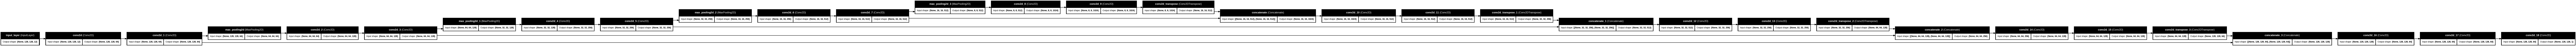

In [35]:
from keras.utils import plot_model

# Save plot as a PNG
plot_model(nn_model,
           to_file='unet_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir="LR",
           dpi=200
           )

           # dpi = 96 the resolution of the image saved
           # rankdir="LR" makes the graph layout left-to-right instead of top-to-bottom. That can reduce complexity.

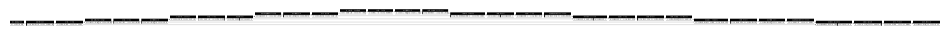

In [36]:
# Display Model Architecture
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('unet_architecture.png')
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()

### Custom Plot (not preferred, would need to be changed if the model changed)

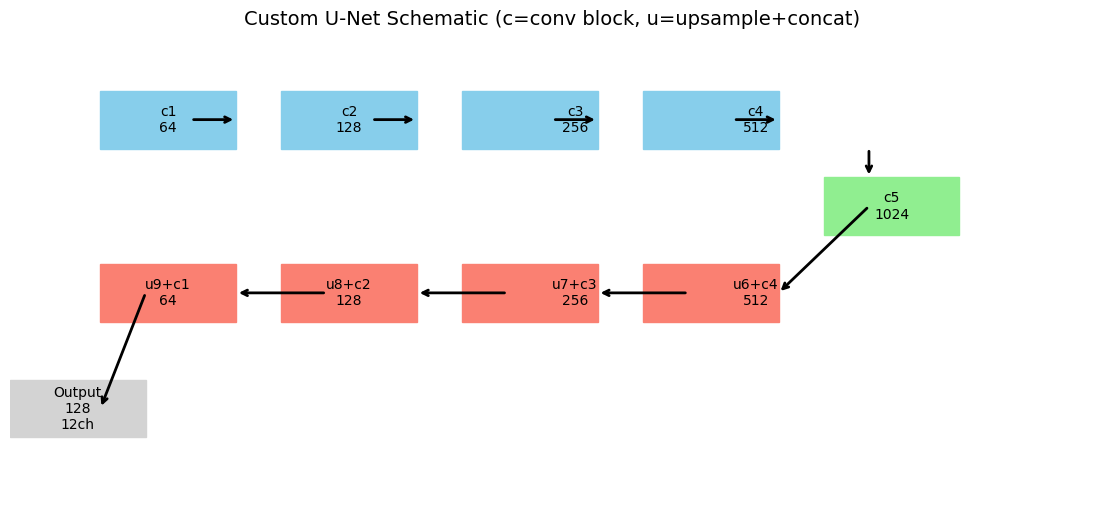

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_unet_schematic():
    fig, ax = plt.subplots(figsize=(14,6))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 8)
    ax.axis('off')

    # Encoder blocks (blue)
    encoder_color = "skyblue"
    ax.add_patch(patches.Rectangle((1,6), 1.5, 1, color=encoder_color))
    ax.text(1.75,6.5,"c1\n64",ha="center",va="center")
    ax.add_patch(patches.Rectangle((3,6), 1.5, 1, color=encoder_color))
    ax.text(3.75,6.5,"c2\n128",ha="center",va="center")
    ax.add_patch(patches.Rectangle((5,6), 1.5, 1, color=encoder_color))
    ax.text(6.25,6.5,"c3\n256",ha="center",va="center")
    ax.add_patch(patches.Rectangle((7,6), 1.5, 1, color=encoder_color))
    ax.text(8.25,6.5,"c4\n512",ha="center",va="center")

    # Bottleneck (green)
    bottleneck_color = "lightgreen"
    ax.add_patch(patches.Rectangle((9,4.5), 1.5, 1, color=bottleneck_color))
    ax.text(9.75,5,"c5\n1024",ha="center",va="center")

    # Decoder blocks (red)
    decoder_color = "salmon"
    ax.add_patch(patches.Rectangle((7,3), 1.5, 1, color=decoder_color))
    ax.text(8.25,3.5,"u6+c4\n512",ha="center",va="center")
    ax.add_patch(patches.Rectangle((5,3), 1.5, 1, color=decoder_color))
    ax.text(6.25,3.5,"u7+c3\n256",ha="center",va="center")
    ax.add_patch(patches.Rectangle((3,3), 1.5, 1, color=decoder_color))
    ax.text(3.75,3.5,"u8+c2\n128",ha="center",va="center")
    ax.add_patch(patches.Rectangle((1,3), 1.5, 1, color=decoder_color))
    ax.text(1.75,3.5,"u9+c1\n64",ha="center",va="center")

    # Output block (gray)
    ax.add_patch(patches.Rectangle((0,1), 1.5, 1, color="lightgray"))
    ax.text(0.75,1.5,"Output\n128\n12ch",ha="center",va="center")

    # Arrows
    arrowprops=dict(arrowstyle="->",lw=2,color="black")
    ax.annotate("", xy=(2.5,6.5), xytext=(2,6.5), arrowprops=arrowprops)
    ax.annotate("", xy=(4.5,6.5), xytext=(4,6.5), arrowprops=arrowprops)
    ax.annotate("", xy=(6.5,6.5), xytext=(6,6.5), arrowprops=arrowprops)
    ax.annotate("", xy=(8.5,6.5), xytext=(8,6.5), arrowprops=arrowprops)
    ax.annotate("", xy=(9.5,5.5), xytext=(9.5,6), arrowprops=arrowprops)

    ax.annotate("", xy=(8.5,3.5), xytext=(9.5,5), arrowprops=arrowprops)
    ax.annotate("", xy=(6.5,3.5), xytext=(7.5,3.5), arrowprops=arrowprops)
    ax.annotate("", xy=(4.5,3.5), xytext=(5.5,3.5), arrowprops=arrowprops)
    ax.annotate("", xy=(2.5,3.5), xytext=(3.5,3.5), arrowprops=arrowprops)
    ax.annotate("", xy=(1,1.5), xytext=(1.5,3.5), arrowprops=arrowprops)

    plt.title("Custom U-Net Schematic (c=conv block, u=upsample+concat)", fontsize=14)
    plt.show()

plot_unet_schematic()

---

# 10 - METRICS (functional metric functions)

**Keras accepts function metrics that take (y_true, y_pred) and return a tensor.**

### Intersection over Union (IoU) metric (commonly used for evaluating the performance of segmentation models)

In [38]:
def iou_metric(y_true, y_pred, threshold=0.5):
    # y_true, y_pred are tensors (batch, H, W, 1)
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred_bin - y_true * y_pred_bin, axis=[1,2,3])
    iou = (intersection + 1e-7) / (union + 1e-7)
    return tf.reduce_mean(iou)

##### Explanation

* `def iou_metric(y_true, y_pred, threshold=0.5):`: Defines the function `iou_metric` that takes three arguments: `y_true` (the ground truth masks), `y_pred` (the predicted masks from the model), and an optional `threshold` (defaulting to 0.5) to binarize the predictions.

* `y_pred_bin = tf.cast(y_pred > threshold, tf.float32)`: This line binarizes the predicted masks. It checks if each predicted pixel value in `y_pred` is greater than the `threshold`. If it is, the value becomes 1 (water); otherwise, it becomes 0 (not water). The result is cast to a `float32` tensor.

* `y_true = tf.cast(y_true, tf.float32)`: Ensures that the ground truth masks are also of type `float32` for consistent calculations.

* `intersection = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])`: Calculates the intersection between the ground truth and the binarized predictions. Multiplying `y_true` and `y_pred_bin` results in a tensor where only the pixels that are 1 in both the ground truth and prediction remain 1. Summing over axes 1, 2, and 3 (height, width, and channel) gives the total number of intersecting pixels for each image in the batch.

* `union = tf.reduce_sum(y_true + y_pred_bin - y_true * y_pred_bin, axis=[1,2,3])`: Calculates the union of the ground truth and the binarized predictions. The formula `A + B - A*B` is the set theory way to calculate the union of two binary sets. Summing over axes 1, 2, and 3 gives the total number of pixels in the union for each image in the batch.

* `iou = (intersection + 1e-7) / (union + 1e-7)`: Calculates the IoU for each image in the batch by dividing the intersection by the union. A small epsilon (1e-7) is added to both the numerator and denominator to prevent division by zero in cases where both intersection and union are zero.

* `return tf.reduce_mean(iou)`: Returns the mean IoU across all images in the batch. This provides a single metric representing the average segmentation performance for the current batch.

##### IOU in simple terms

Imagine you have two shapes, like two circles. IoU, or Intersection over Union, is a way to measure how much those two circles overlap.

Here's the simple idea:

1. **Intersection**: This is the area where the two circles overlap.

2. **Union**: This is the total area covered by both circles combined (the area of the first circle plus the area of the second circle, minus the area of the overlap so you don't count it twice).
IoU is calculated like this:

**IoU = (Area of Intersection) / (Area of Union)**

Think of it like this:

* If the two circles don't overlap at all, the intersection is 0, so the IoU is 0.

* If the two circles overlap perfectly (they are the exact same circle), the intersection is equal to the union, so the IoU is 1 (or 100%).

* If they partially overlap, the IoU will be somewhere between 0 and 1.

In the context of image segmentation (like finding water in satellite images), the two "shapes" are:

1. The ground truth mask (the actual area of water).

2. The predicted mask from your model (the area your model thinks is water).

So, IoU tells you how well your model's prediction of where the water is matches the actual location of the water. A higher IoU means a better match!

### Precision Metric

In [39]:
def precision_metric(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])
    prec = tp / (tf.reduce_sum(y_pred_bin, axis=[1,2,3]) + 1e-7)
    return tf.reduce_mean(prec)

### Recall Metric

In [40]:
def recall_metric(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])
    rec = tp / (tf.reduce_sum(y_true, axis=[1,2,3]) + 1e-7)
    return tf.reduce_mean(rec)

### f1 Score Metric

In [41]:
def f1_metric(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])
    # precision
    prec = tp / (tf.reduce_sum(y_pred_bin, axis=[1,2,3]) + 1e-7)
    # recall
    rec = tp / (tf.reduce_sum(y_true, axis=[1,2,3]) + 1e-7)
    # F1 Score
    f1 = 2 * prec * rec / (prec + rec + 1e-7)
    return tf.reduce_mean(f1)

##### Explanation

This code defines a function `f1_metric` that calculates the **F1 score**, another metric used to evaluate the performance of segmentation models. Here's a breakdown:

* `def f1_metric(y_true, y_pred, threshold=0.5):`: Defines the function `f1_metric` with `y_true` (ground truth masks), `y_pred` (predicted masks), and an optional `threshold` for binarization.

* `y_pred_bin = tf.cast(y_pred > threshold, tf.float32)`: Binarizes the predicted masks based on the threshold.

* `y_true = tf.cast(y_true, tf.float32)`: Ensures the ground truth masks are `float32`.

* `tp = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])`: Calculates `True Positives` **(TP)** by summing the pixels where both ground truth and prediction are 1.

* `prec = tp / (tf.reduce_sum(y_pred_bin, axis=[1,2,3]) + 1e-7)`: Calculates `Precision`. `Precision` is `TP` divided by the total number of `predicted positive pixels` **(TP + False Positives)**. `tf.reduce_sum(y_pred_bin, axis=[1,2,3])` gives the **total predicted positive pixels**. A small epsilon is added to prevent division by zero.

* `rec = tp / (tf.reduce_sum(y_true, axis=[1,2,3]) + 1e-7)`: Calculates `Recall`. `Recall` is `TP` divided by the `total number of actual positive pixels` **(TP + False Negatives)**. `tf.reduce_sum(y_true, axis=[1,2,3])` gives the **total actual positive pixels**. A small epsilon is added.

* `f1 = 2 * prec * rec / (prec + rec + 1e-7)`: Calculates the `F1 score`, which is the **harmonic mean of Precision and Recall**. It provides a single score that balances both metrics. A small epsilon is added to prevent division by zero.

* `return tf.reduce_mean(f1)`: Returns the mean F1 score across all images in the batch.

---

# 11 - COMPILE & TRAIN

In [42]:
from keras.optimizers import Adam

LEARNING_RATE = 1e-4

nn_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=[iou_metric, precision_metric, recall_metric, f1_metric])

In [43]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
nn_model_callbacks = [
    # ModelCheckpoint to save the best model based on validation IoU
    ModelCheckpoint('best_unet_model.keras', monitor='val_iou_metric', save_best_only=True, mode='max', verbose=1),

    # ReduceLROnPlateau to reduce learning rate when validation IoU plateaus
    ReduceLROnPlateau(monitor='val_iou_metric',
                      factor=0.5, # Factor by which the learning rate will be reduced. new_lr = lr * factor
                      patience=3, # Number of epochs with no improvement after which the learning rate will be reduced.
                      mode='max',
                      min_lr=0.000001, # Lower bound on the learning rate (1e-6).
                      verbose=1)
]

In [44]:
EPOCHS = 80

print("Model is Fitting...")
nn_model_fit = nn_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=EPOCHS,
                            callbacks=nn_model_callbacks)  # batch_size was done on the [7] tf.dataset part, the dataset will be fitted with the batch_size already declared

Model is Fitting...
Epoch 1/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_metric: 0.5782 - iou_metric: 0.5135 - loss: 0.6328 - precision_metric: 0.5625 - recall_metric: 0.6566   
Epoch 1: val_iou_metric improved from -inf to 0.89740, saving model to best_unet_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - f1_metric: 0.5892 - iou_metric: 0.5259 - loss: 0.6280 - precision_metric: 0.5727 - recall_metric: 0.6661 - val_f1_metric: 0.8384 - val_iou_metric: 0.8974 - val_loss: 0.3840 - val_precision_metric: 0.8224 - val_recall_metric: 0.8628 - learning_rate: 1.0000e-04
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - f1_metric: 0.7994 - iou_metric: 0.8599 - loss: 0.2901 - precision_metric: 0.8174 - recall_metric: 0.7998
Epoch 2: val_iou_metric did not improve from 0.89740
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step - f1_metric: 0.7990 - iou_metric: 0.8590 - loss: 0.2834 - precision_metric: 0.8178 - recall_metric: 0.7987 - val_f1_metric: 0.8143 - val_iou_metric: 0.8672 - val_loss: 0.080



---

# 12 - VISUALIZATION: bands and predictions

In [45]:
def plot_bands(img_hwc, title_prefix="Sample"):
    # img_hwc in original scale (if normalized, de-normalize for visualization)
    # we'll plot the 12 bands
    fig, axes = plt.subplots(3,4, figsize=(12,9))
    axes = axes.flatten()
    for i in range(12):
        band = img_hwc[..., i]
        axes[i].imshow(band, cmap='gray')
        axes[i].set_title(f"Band {i+1}")
        axes[i].axis('off')
    plt.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()

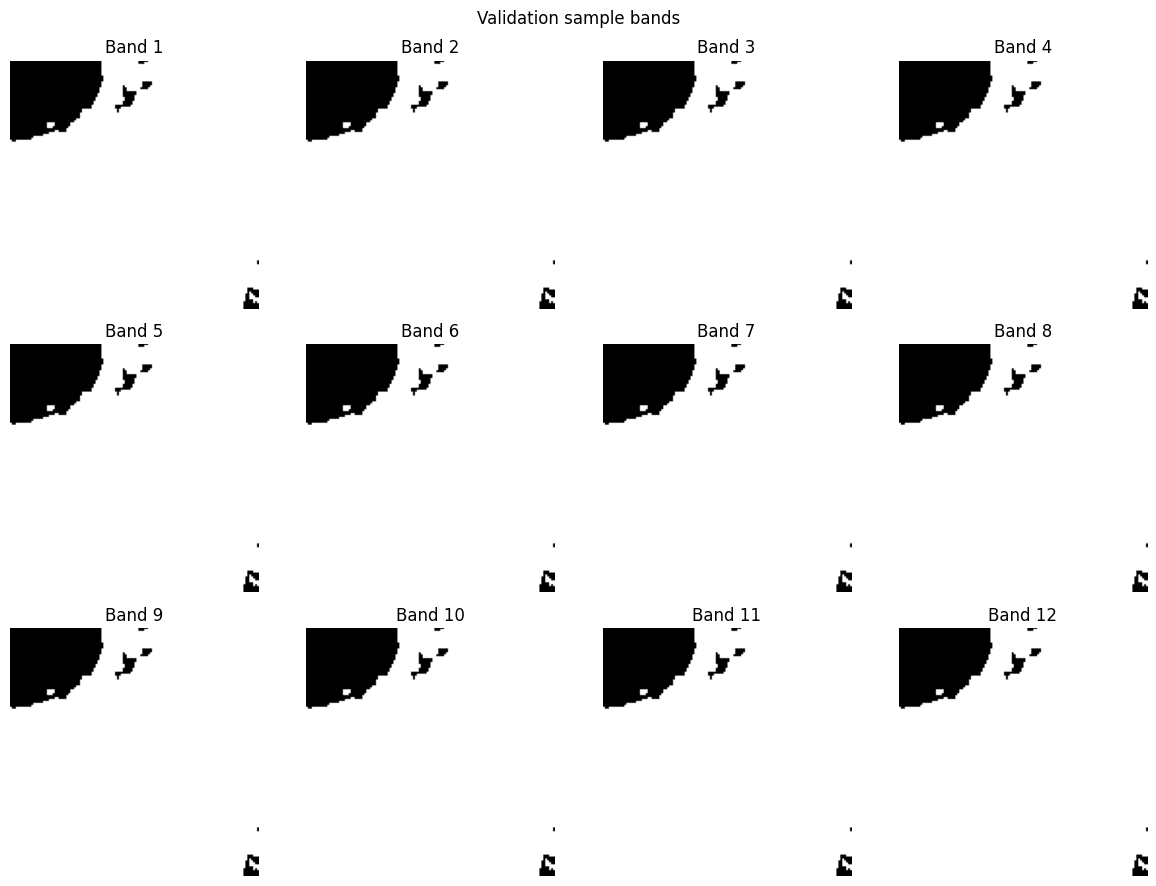

In [46]:
# Pick a validation sample and visualize
sample_idx = 0
sample_img = X_val[sample_idx]
sample_mask = Y_val[sample_idx].squeeze()

# if data was normalized using stats, recover approximate original for band plotting:
means = np.array(stats["means"], dtype=np.float32)
stds = np.array(stats["stds"], dtype=np.float32)
sample_img_vis = (sample_img * stds[None,None,:]) + means[None,None,:]  # de-normalize
plot_bands(sample_img_vis, "Validation sample bands")

#### E:

The code in this cell visualizes the individual spectral bands of a single sample image from your validation dataset.

Here's what each part does:

1. `sample_idx = 0`: Selects the first image in your validation set (`X_val`) to be the sample.

2. `sample_img = X_val[sample_idx]`: Gets the image data for the selected sample. Since `X_val` contains the normalized image data, `sample_img` is the normalized 12-channel image.

3. `sample_mask = Y_val[sample_idx].squeeze()`: Gets the ground truth mask for the same sample and removes the channel dimension (`squeeze`) so it's a 2D mask.

4. `means = np.array(stats["means"], ...)` and `stds = np.array(stats["stds"], ...)`: Retrieves the mean and standard deviation values calculated earlier from your training data. These are needed to reverse the normalization.

5. `sample_img_vis = (sample_img * stds[None,None,:]) + means[None,None,:]`: This is the crucial step for visualization. It **de-normalizes** the `sample_img` using the calculated means and standard deviations. This brings the pixel values back to their approximate original range, making the image visually interpretable.

6. `plot_bands(sample_img_vis, "Validation sample bands")`: Calls the `plot_bands` function (defined) with the de-normalized image data. This function then displays **each of the 12 spectral bands** of that image as a separate grayscale plot in a 3x4 grid.

So, in summary, this cell visualizes the individual bands of one example validation image after reversing the normalization applied during preprocessing, allowing you to see the raw appearance of the image data across different wavelengths.

#### predicting a single band:

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


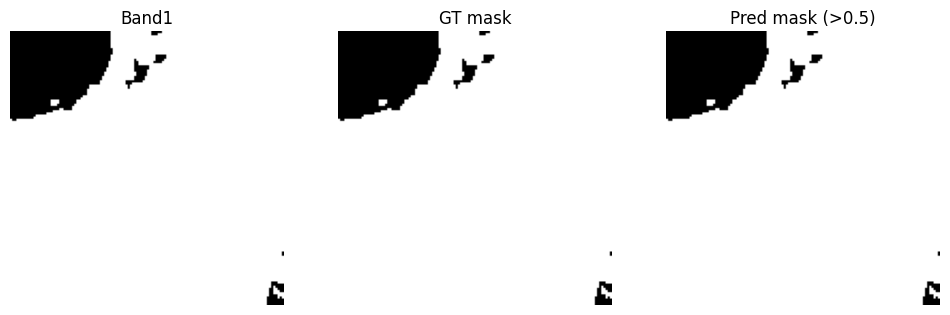

In [47]:
# show prediction
pred = nn_model.predict(sample_img[None,...])[0,...,0]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample_img_vis[...,0], cmap='gray'); plt.title("Band1"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(sample_mask, cmap='gray'); plt.title("GT mask"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(pred>0.5, cmap='gray'); plt.title("Pred mask (>0.5)"); plt.axis('off')
plt.show()

---

# 13 -  SAVE MODEL / PREDICTIONS

In [48]:
# Save model weights and an example prediction folder
MODEL_SAVE_PATH = "/content/unet_water_model.keras"
nn_model.save(MODEL_SAVE_PATH)
print("Saved model to", MODEL_SAVE_PATH)

Saved model to /content/unet_water_model.keras


In [55]:
PREDICTED_MASKS_DIR = "/content/pred_masks"

In [56]:
import shutil

# Remove the directory and all its contents
if os.path.exists(PREDICTED_MASKS_DIR):
    print(f"Removing existing directory: {PREDICTED_MASKS_DIR}")
    shutil.rmtree(PREDICTED_MASKS_DIR)
    print("Directory removed.")
else:
    print(f"Directory not found: {PREDICTED_MASKS_DIR}. No need to remove.")

Removing existing directory: /content/pred_masks
Directory removed.


In [57]:
os.makedirs(PREDICTED_MASKS_DIR, exist_ok=True)
for i,p in enumerate(val_imgs[:]):
    inp = X_val[i:i+1]  # shape (1,H,W,12)
    pred = nn_model.predict(inp)[0,...,0]
    out_mask = (pred > 0.5).astype(np.uint8) * 255
    out_name = Path(p).stem + "_pred.png"
    cv2.imwrite(str(Path(PREDICTED_MASKS_DIR)/out_name), out_mask)
print("Saved example predictions to", PREDICTED_MASKS_DIR)

# Count the number of files in the directory
num_predicted_masks = len(os.listdir(PREDICTED_MASKS_DIR))
print(f"Number of predicted masks saved: {num_predicted_masks}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

In [60]:
### Downloading the pred_masks file

import shutil
from google.colab import files

# Define the directory to zip and the output zip file name
directory_to_zip = PREDICTED_MASKS_DIR # Or "/content/pred_masks"
output_zip_filename = 'predicted_masks.zip'

# Create a zip archive of the directory
shutil.make_archive(output_zip_filename.replace('.zip', ''), 'zip', directory_to_zip)

# Download the zip file
files.download(output_zip_filename)

print(f"Folder '{directory_to_zip}' zipped and ready for download as '{output_zip_filename}'.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder '/content/pred_masks' zipped and ready for download as 'predicted_masks.zip'.


In [58]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path

def visualize_predictions(image_paths, ground_truth_masks, predicted_masks_dir, num_samples=20):
    """
    Visualizes original images, ground truth masks, and predicted masks side-by-side.

    Args:
        image_paths (list): List of paths to the original images.
        ground_truth_masks (list): List of paths to the ground truth masks.
        predicted_masks_dir (str): Directory containing the predicted masks.
        num_samples (int): Number of random samples to display.
    """
    # Ensure the number of samples doesn't exceed the available images
    num_samples = min(num_samples, len(image_paths))

    # Get random indices
    sample_indices = random.sample(range(len(image_paths)), num_samples)

    print(f"Displaying {num_samples} random samples:")

    for i in sample_indices:
        img_path = image_paths[i]
        gt_mask_path = ground_truth_masks[i]

        # Construct the predicted mask path (assuming same stem with _pred.png suffix)
        img_stem = Path(img_path).stem
        pred_mask_name = img_stem + "_pred.png"
        pred_mask_path = Path(predicted_masks_dir) / pred_mask_name

        # Read the images and masks
        # Use the read_image function defined earlier
        # For visualization, we might only need a few bands, e.g., RGB (bands 3, 2, 1 assuming 0-indexed)
        # Need to handle potential normalization if read_image returns normalized data
        try:
            original_img_raw = read_image(img_path) # Use the defined read_image function

            # Simple visualization: use first 3 bands and scale to 0-255 if needed
            # Check if stats exist and denormalize if necessary
            if 'stats' in globals() and stats is not None:
                 means = np.array(stats["means"], dtype=np.float32)
                 stds = np.array(stats["stds"], dtype=np.float32)
                 # Assuming original_img_raw is already normalized if stats exist and apply_normalization was used on X_val
                 # If read_image returns raw data, and X_val was normalized separately, this might need adjustment
                 # For simplicity here, let's assume read_image returns raw data and we scale first 3 bands for visualization
                 # If read_image returns normalized data, you need to denormalize it first
                 # Let's use a simple scaling for demonstration if it's not already 0-255
                 vis_img = original_img_raw[..., :3] # Take first 3 bands
                 vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min() + 1e-8) * 255 # Simple scaling
                 vis_img = vis_img.astype(np.uint8)
            else:
                 # Assume read_image returns raw data, scale first 3 bands
                 vis_img = original_img_raw[..., :3] # Take first 3 bands
                 vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min() + 1e-8) * 255 # Simple scaling
                 vis_img = vis_img.astype(np.uint8)


            gt_mask = read_mask(gt_mask_path) # Use the defined read_mask function
            pred_mask = cv2.imread(str(pred_mask_path), cv2.IMREAD_GRAYSCALE)

            if pred_mask is None:
                print(f"Warning: Predicted mask not found for {img_stem}")
                continue

            # Ensure masks are binary (0 or 1) for display
            gt_mask_display = gt_mask * 255 # Scale 0/1 to 0/255 for visualization
            pred_mask_display = pred_mask # Predicted masks are already 0/255

            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(vis_img)
            axes[0].set_title(f"Original Image (Sample {i})")
            axes[0].axis('off')

            axes[1].imshow(gt_mask_display, cmap='gray')
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            axes[2].imshow(pred_mask_display, cmap='gray')
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

        except FileNotFoundError as e:
            print(f"Error loading file: {e}")
        except Exception as e:
            print(f"An error occurred for sample {i}: {e}")

Displaying 10 random samples:


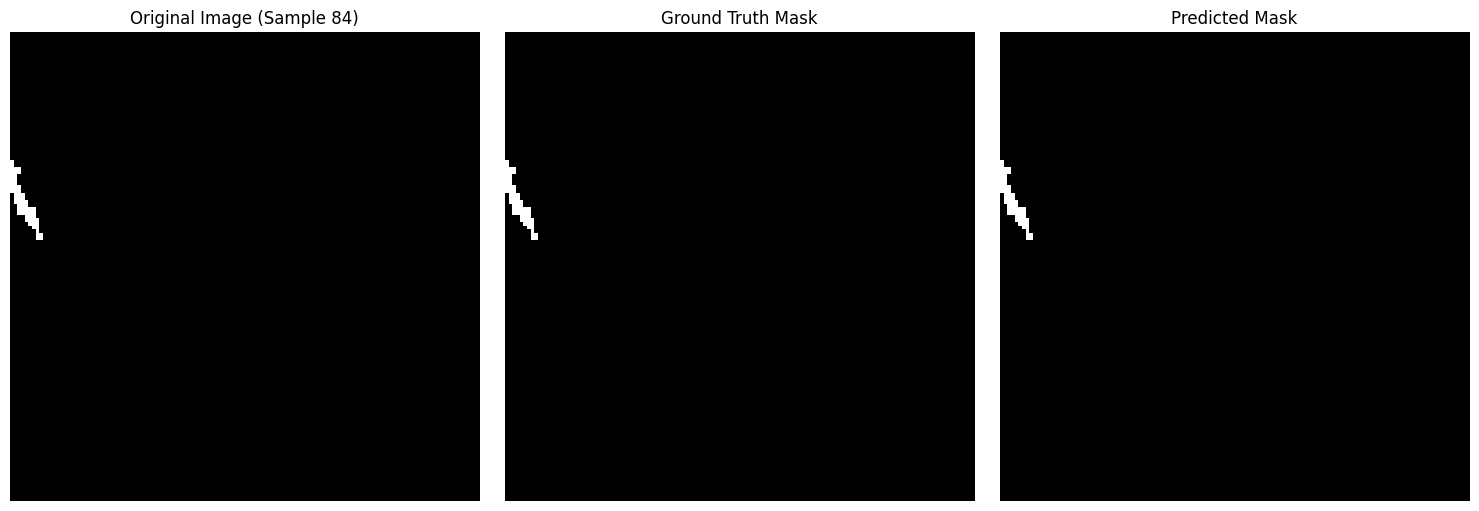

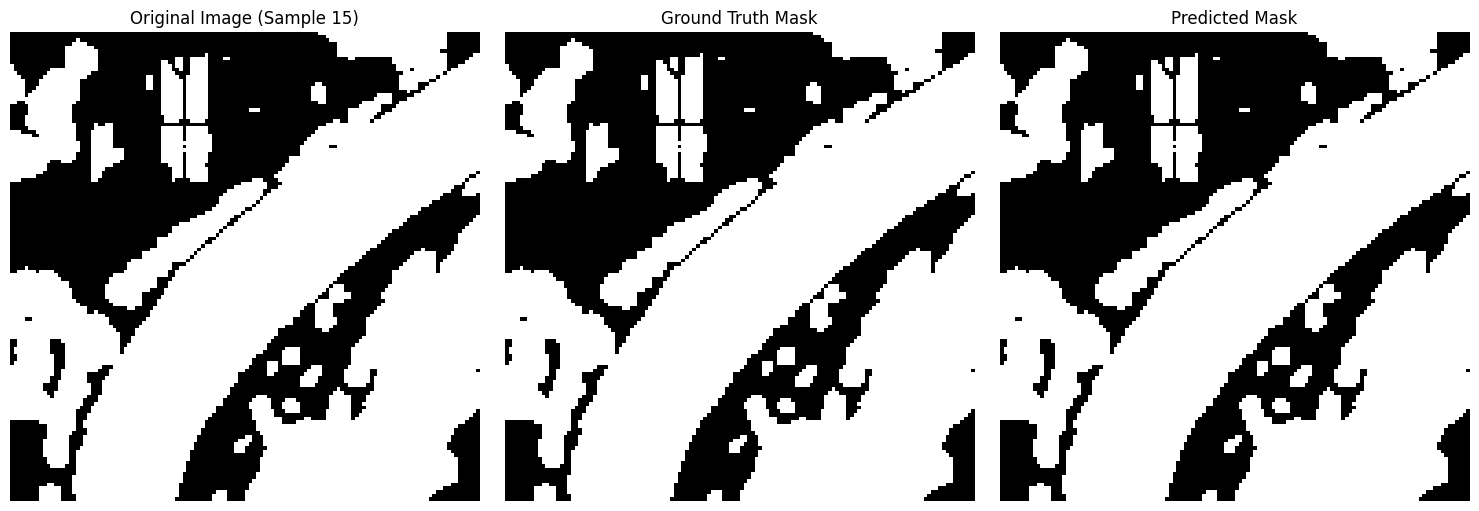

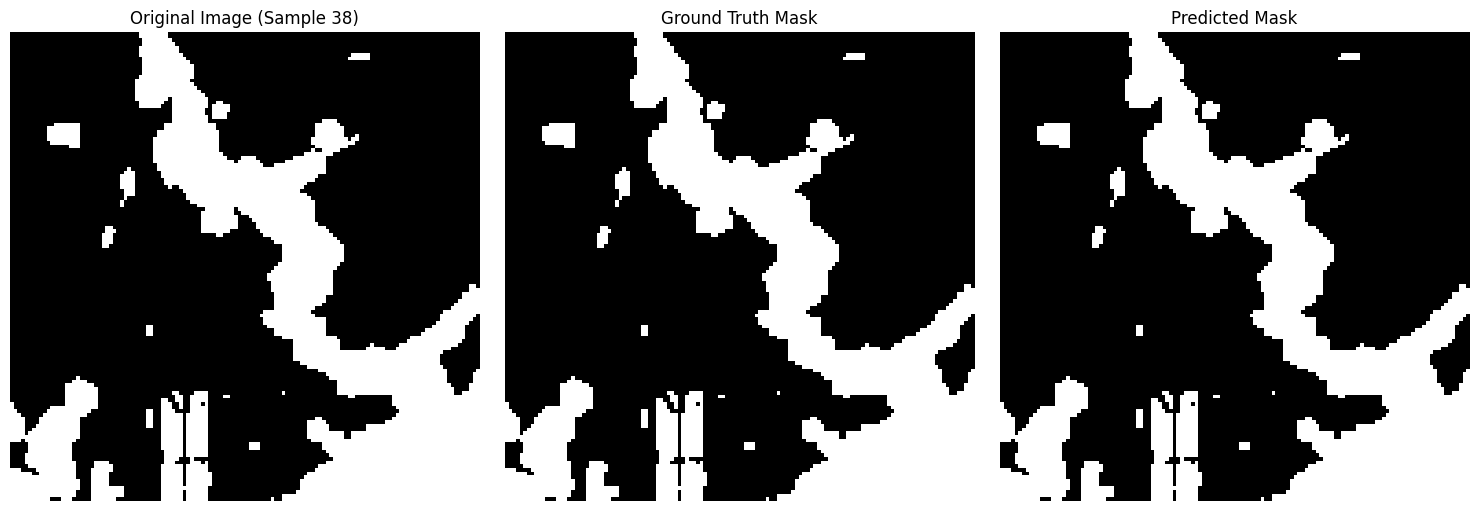

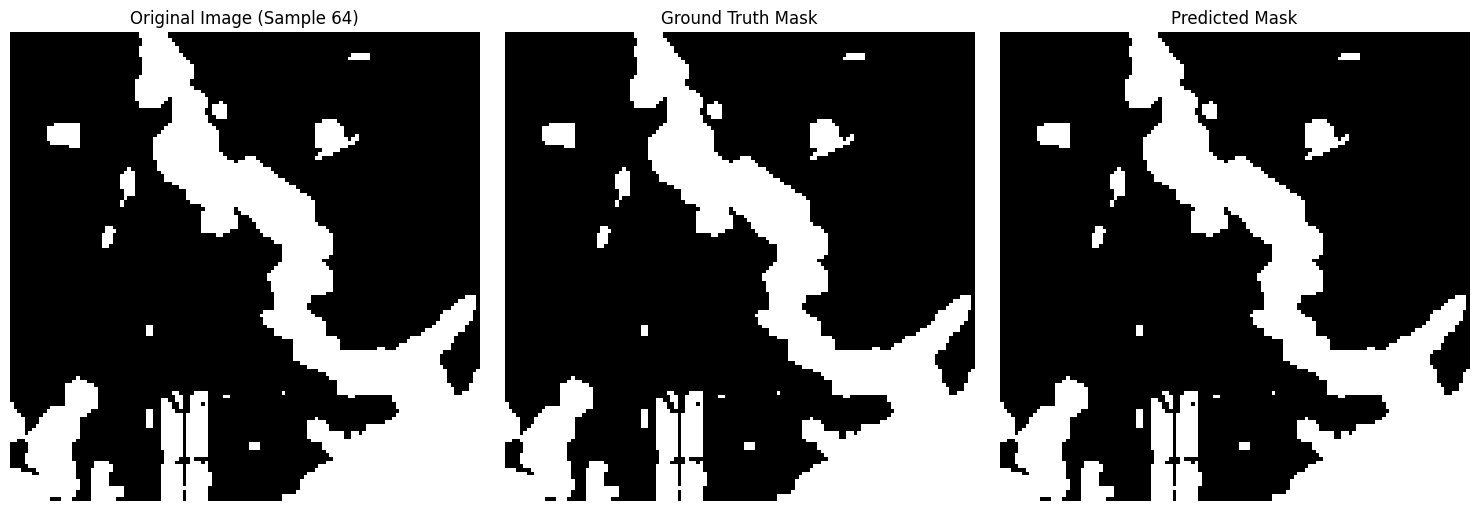

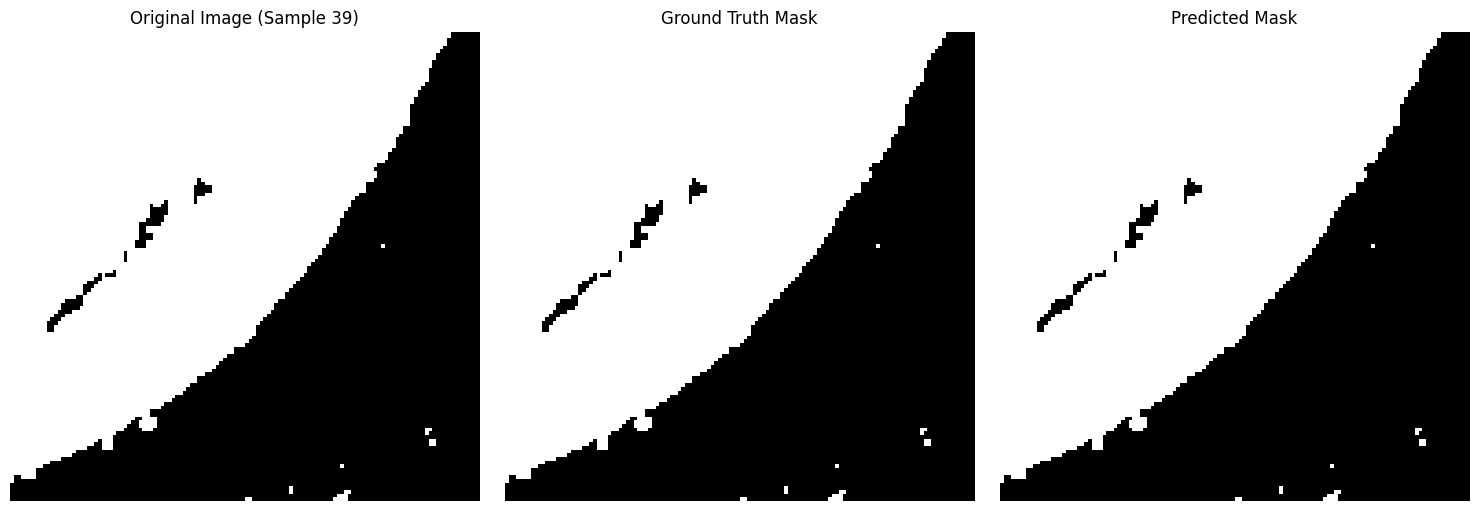

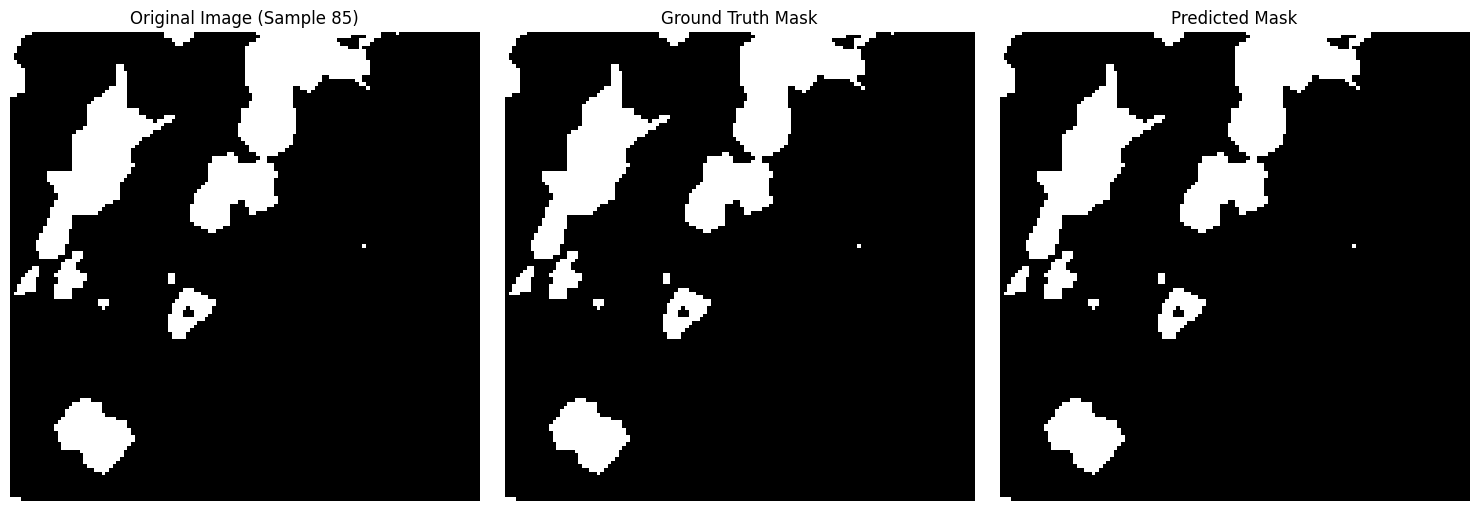

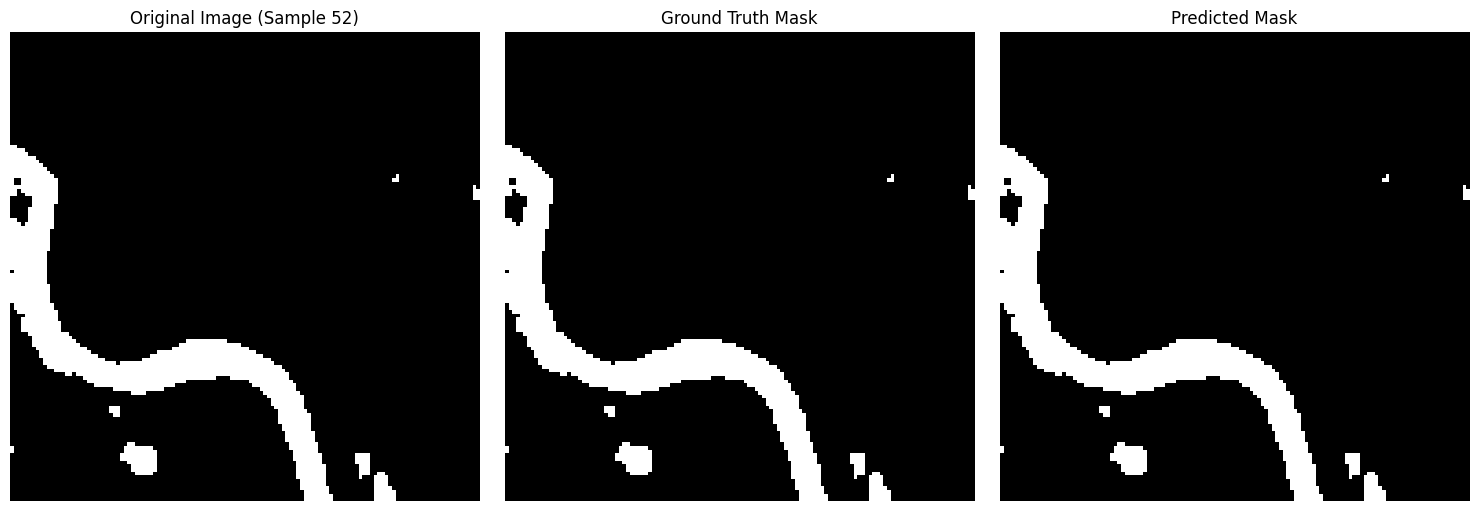

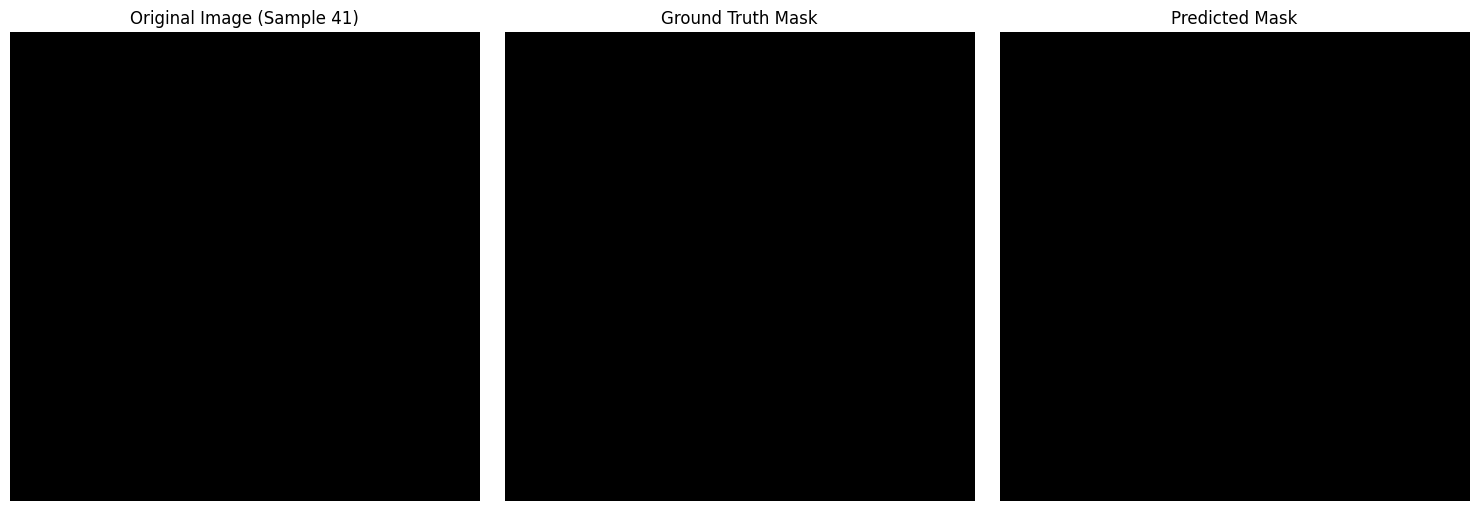

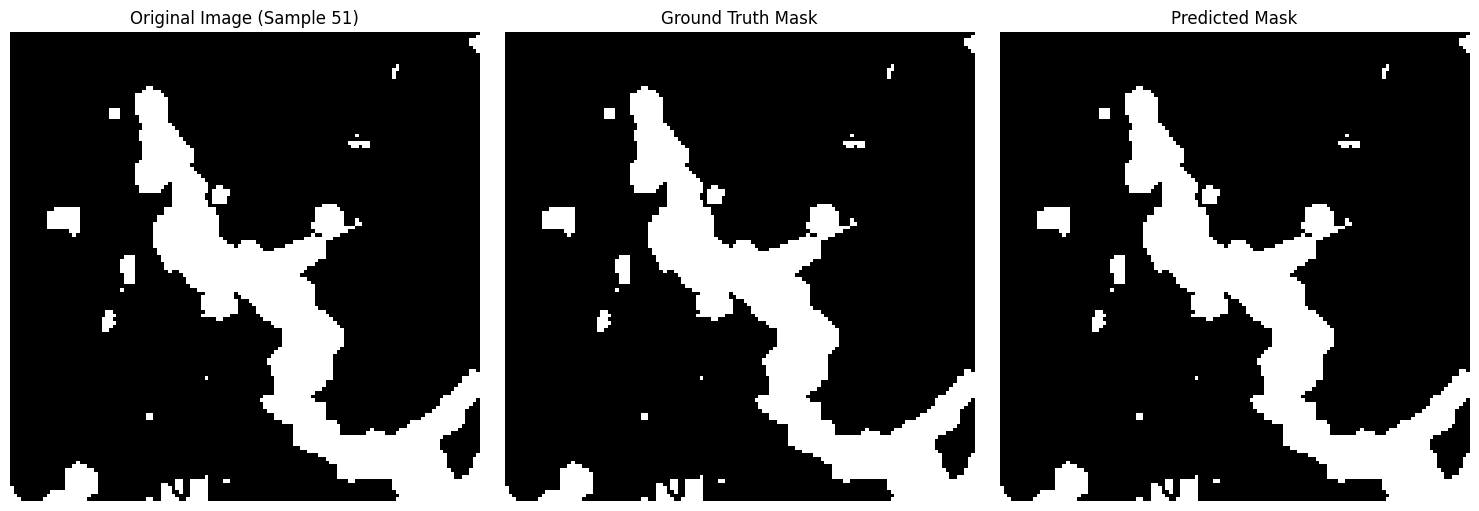

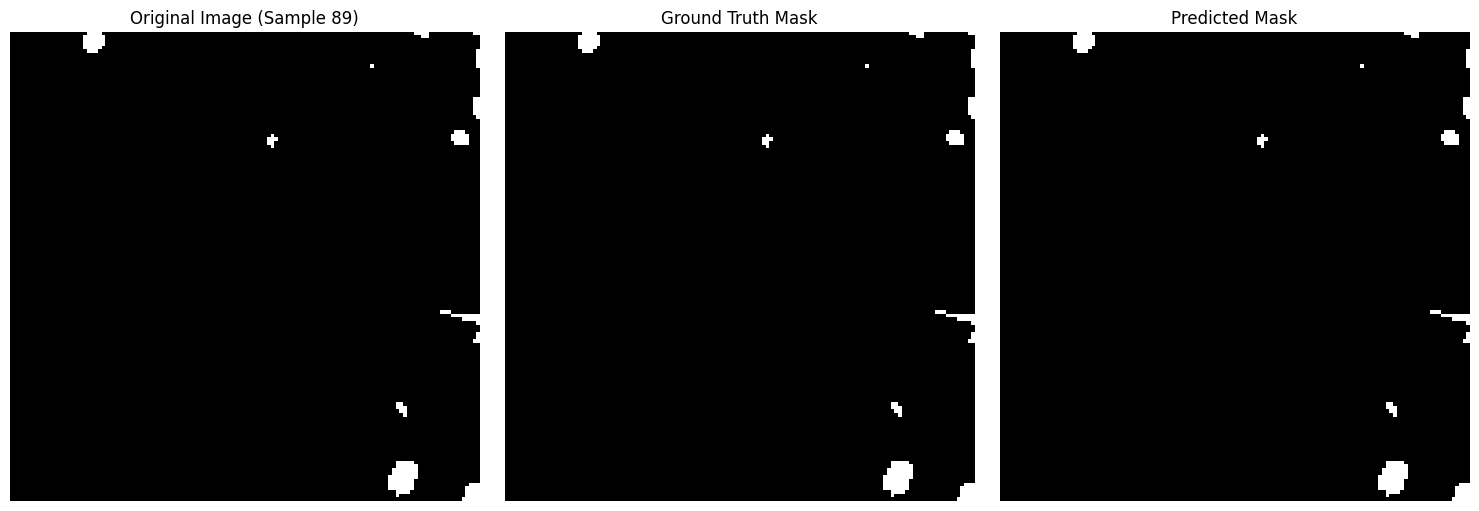

In [59]:
if 'val_imgs' in globals() and 'val_masks' in globals() and 'PREDICTED_MASKS_DIR' in globals():
     # Ensure val_masks is not None if you want to show ground truth
     if val_masks is not None:
         visualize_predictions(val_imgs, val_masks, PREDICTED_MASKS_DIR, num_samples=10)
     else:
         print("Ground truth masks (val_masks) are not available to plot.")
else:
    print("Required variables (val_imgs, val_masks, OUT_DIR) not found. Please run previous cells.")

##### E:

In these prediction mask images:

* White pixels** (value 255 or 1) represent the areas where your model has predicted the presence of water bodies.

* **Black pixels** (value 0) represent the areas where your model has predicted not water (background/land).

the code currently visualizes **the first 3 bands** of the original image, not just one.

This line is responsible for selecting the bands for visualization:


```
vis_img = original_img_raw[..., :3] # Take first 3 bands
```

This takes a slice of the `original_img_raw` NumPy array along the last axis (the channel dimension), selecting the first three channels (indices 0, 1, and 2). These are then used to create a simple visualization of the image, often representing a form of RGB composite depending on what those first three bands correspond to in your dataset.

#### Water Body detection in Blue

In [62]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
import matplotlib.colors as mcolors

def visualize_predictions_blue(image_paths, ground_truth_masks, predicted_masks_dir, num_samples=20):
    """
    Visualizes original images, ground truth masks, and predicted masks side-by-side.

    Args:
        image_paths (list): List of paths to the original images.
        ground_truth_masks (list): List of paths to the ground truth masks.
        predicted_masks_dir (str): Directory containing the predicted masks.
        num_samples (int): Number of random samples to display.
    """
    # Ensure the number of samples doesn't exceed the available images
    num_samples = min(num_samples, len(image_paths))

    # Get random indices
    sample_indices = random.sample(range(len(image_paths)), num_samples)

    print(f"Displaying {num_samples} random samples:")

    # Define a custom colormap: 0 -> black, 1 -> sky blue
    colors = [(0, 0, 0), mcolors.CSS4_COLORS['skyblue']] # Black for 0, SkyBlue for 1
    cmap = mcolors.ListedColormap(colors)
    bounds = [-0.5, 0.5, 1.5] # Define bounds for the colormap
    norm = mcolors.BoundaryNorm(bounds, cmap.N)


    for i in sample_indices:
        img_path = image_paths[i]
        gt_mask_path = ground_truth_masks[i]

        # Construct the predicted mask path (assuming same stem with _pred.png suffix)
        img_stem = Path(img_path).stem
        pred_mask_name = img_stem + "_pred.png"
        pred_mask_path = Path(predicted_masks_dir) / pred_mask_name

        # Read the images and masks
        # Use the read_image function defined earlier (assuming it's available)
        # For visualization, we might only need a few bands, e.g., RGB (bands 3, 2, 1 assuming 0-indexed)
        # Need to handle potential normalization if read_image returns normalized data
        try:
            original_img_raw = read_image(img_path) # Use the defined read_image function

            # Simple visualization: use first 3 bands and scale to 0-255 if needed
            # Check if stats exist and denormalize if necessary
            if 'stats' in globals() and stats is not None:
                 means = np.array(stats["means"], dtype=np.float32)
                 stds = np.array(stats["stds"], dtype=np.float32)
                 # Assuming original_img_raw is already normalized if stats exist and apply_normalization was used on X_val
                 # If read_image returns raw data, and X_val was normalized separately, this might need adjustment
                 # For simplicity here, let's assume read_image returns raw data and we scale first 3 bands for visualization
                 # If read_image returns normalized data, you need to denormalize it first
                 # Let's use a simple scaling for demonstration if it's not already 0-255
                 vis_img = original_img_raw[..., :3] # Take first 3 bands
                 vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min() + 1e-8) * 255 # Simple scaling
                 vis_img = vis_img.astype(np.uint8)
            else:
                 # Assume read_image returns raw data, scale first 3 bands
                 vis_img = original_img_raw[..., :3] # Take first 3 bands
                 vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min() + 1e-8) * 255 # Simple scaling
                 vis_img = vis_img.astype(np.uint8)


            gt_mask = read_mask(gt_mask_path) # Use the defined read_mask function
            pred_mask = cv2.imread(str(pred_mask_path), cv2.IMREAD_GRAYSCALE)

            if pred_mask is None:
                print(f"Warning: Predicted mask not found for {img_stem}")
                continue

            # Ensure masks are binary (0 or 1) for display
            # Scale 0/1 to 0/255 to match the loaded predicted mask format (which is 0/255)
            # We will then use the custom colormap
            gt_mask_display = gt_mask # gt_mask is already 0/1 or 0/255 depending on read_mask. Let's ensure it's 0/1 if we use the custom cmap
            # Ensure gt_mask_display is 0 or 1
            if gt_mask_display.max() > 1:
                gt_mask_display = (gt_mask_display > 128).astype(np.uint8) # Assuming 255 was used for 1


            pred_mask_display = (pred_mask > 128).astype(np.uint8) # Ensure predicted mask is 0 or 1 if it was 0/255


            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(vis_img)
            axes[0].set_title(f"Original Image (Sample {i})")
            axes[0].axis('off')

            # Use the custom colormap and normalization for masks
            axes[1].imshow(gt_mask_display, cmap=cmap, norm=norm)
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            axes[2].imshow(pred_mask_display, cmap=cmap, norm=norm)
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

        except FileNotFoundError as e:
            print(f"Error loading file: {e}")
        except Exception as e:
            print(f"An error occurred for sample {i}: {e}")


Displaying 5 random samples:


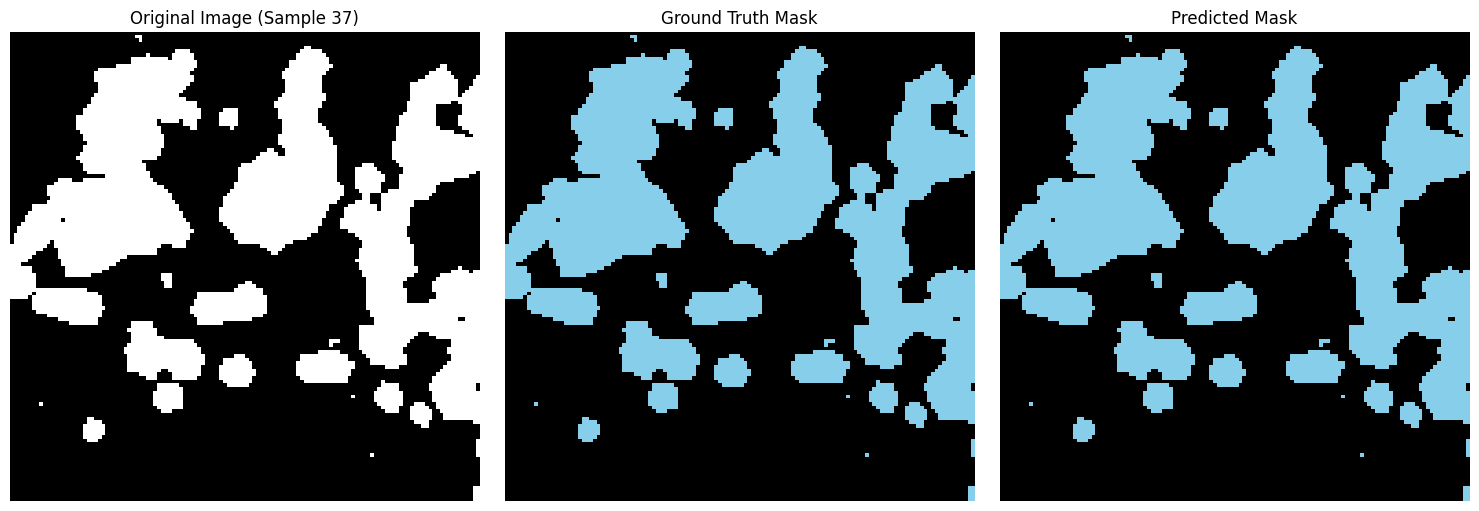

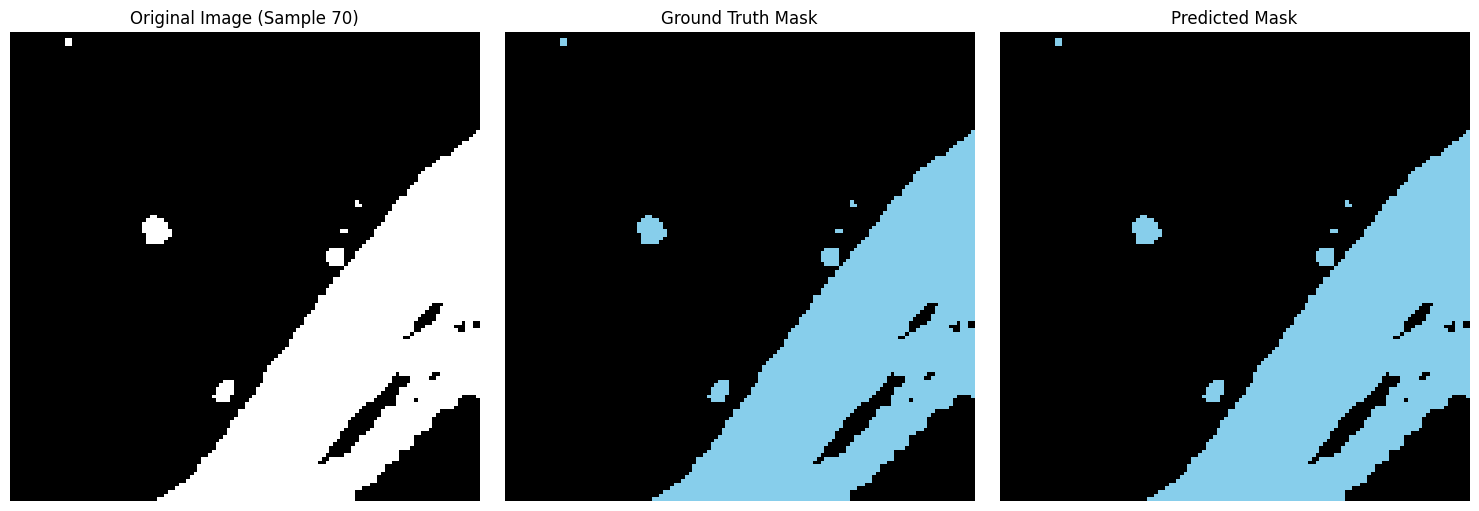

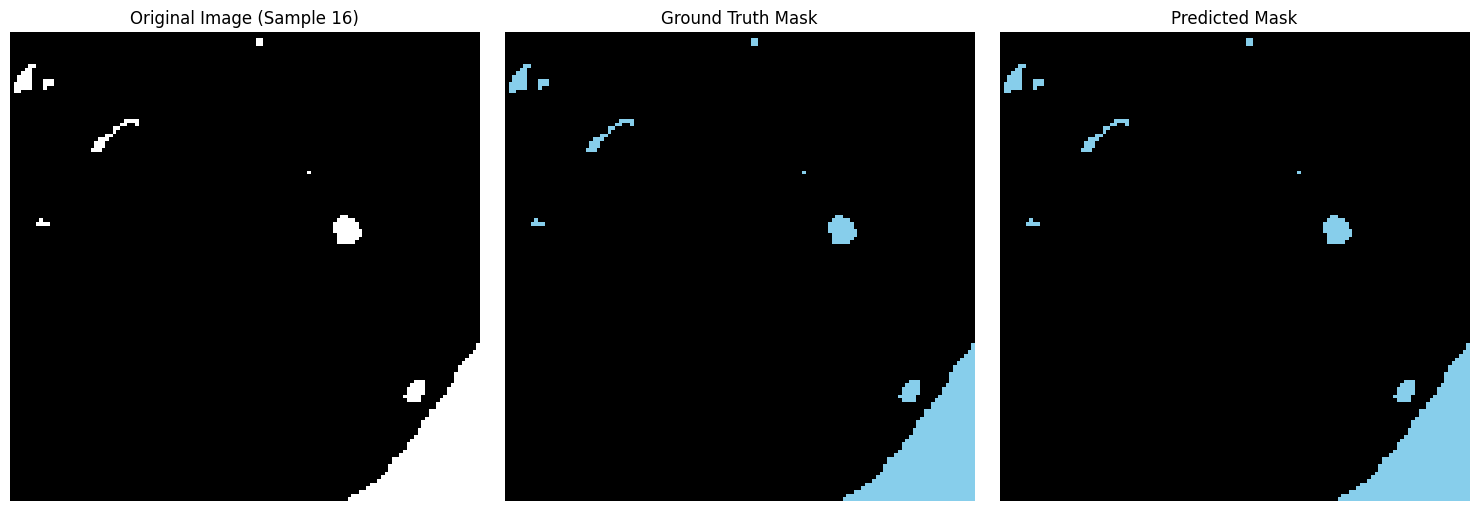

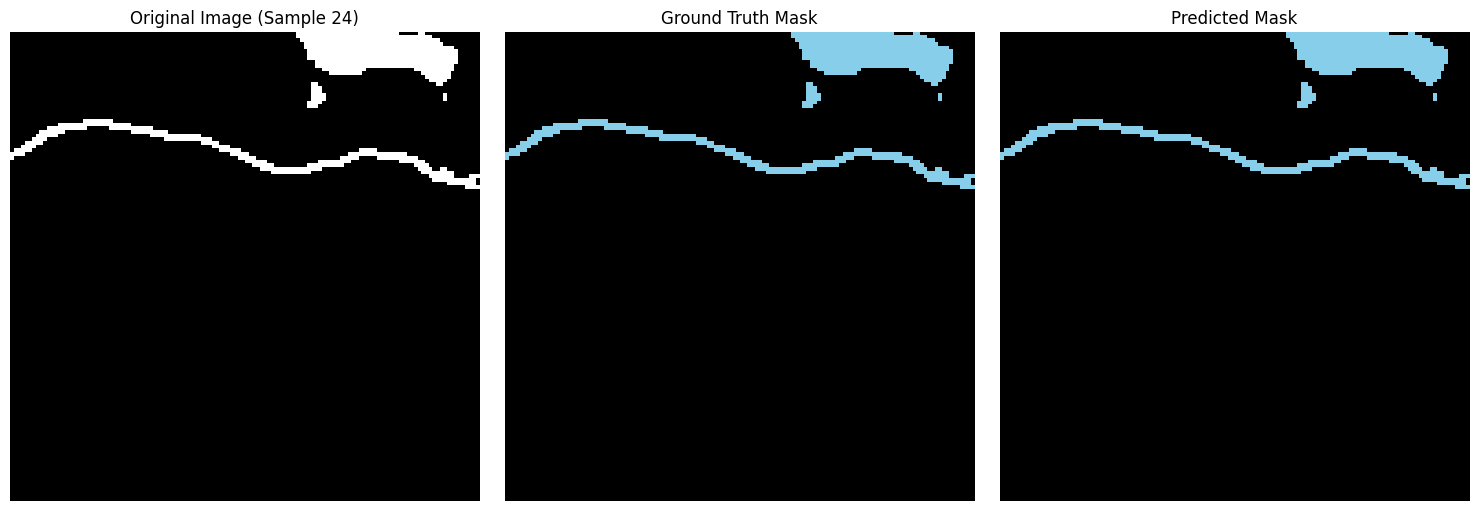

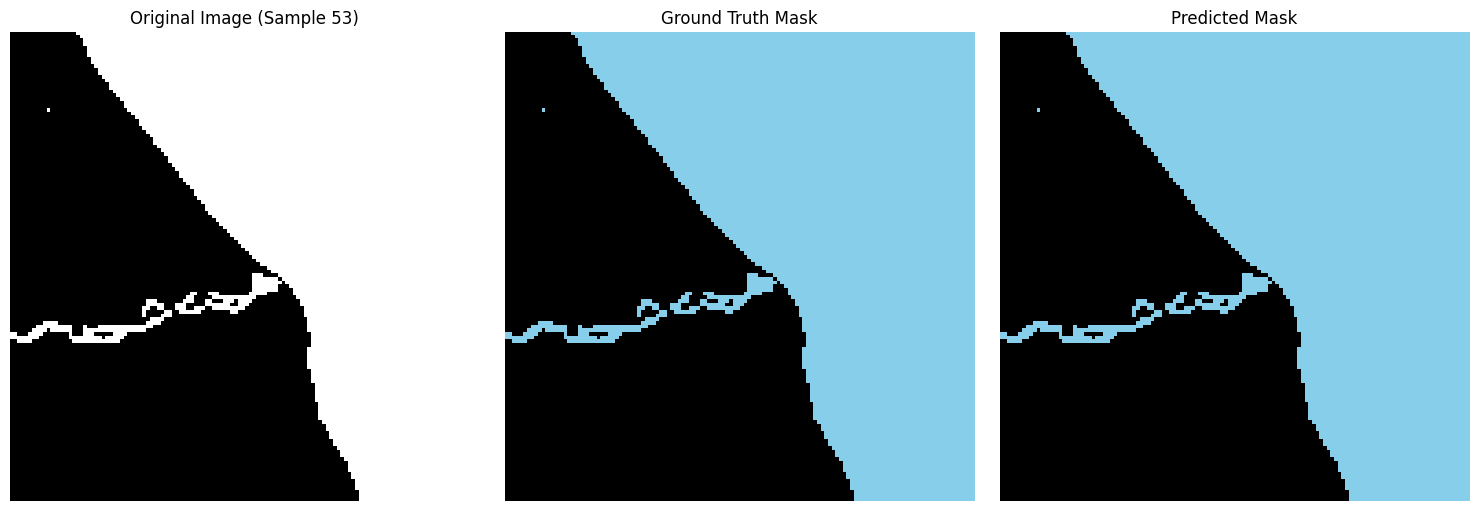

In [63]:
if 'val_imgs' in globals() and 'val_masks' in globals() and 'OUT_DIR' in globals():
     # Ensure val_masks is not None if you want to show ground truth
     if val_masks is not None:
         visualize_predictions_blue(val_imgs, val_masks, PREDICTED_MASKS_DIR, num_samples=5)
     else:
         print("Ground truth masks (val_masks) are not available to plot.")
else:
    print("Required variables (val_imgs, val_masks, OUT_DIR) not found. Please run previous cells.")

#### Water Body detection in Blue for RGB Images

In [76]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
import matplotlib.colors as mcolors

def visualize_predictions_rgb(image_paths, ground_truth_masks, predicted_masks_dir, num_samples=20):
    """
    Visualizes original images (using RGB bands), ground truth masks, and predicted masks side-by-side.

    Args:
        image_paths (list): List of paths to the original images.
        ground_truth_masks (list): List of paths to the ground truth masks.
        predicted_masks_dir (str): Directory containing the predicted masks.
        num_samples (int): Number of random samples to display.
    """
    # Ensure the number of samples doesn't exceed the available images
    num_samples = min(num_samples, len(image_paths))

    # Get random indices
    sample_indices = random.sample(range(len(image_paths)), num_samples)

    print(f"Displaying {num_samples} random samples:")

    # Define a custom colormap: 0 -> black, 1 -> sky blue
    colors = [(0, 0, 0), mcolors.CSS4_COLORS['skyblue']] # Black for 0, SkyBlue for 1
    cmap = mcolors.ListedColormap(colors)
    bounds = [-0.5, 0.5, 1.5] # Define bounds for the colormap
    norm = mcolors.BoundaryNorm(bounds, cmap.N)


    for i in sample_indices:
        img_path = image_paths[i]
        gt_mask_path = ground_truth_masks[i]

        # Construct the predicted mask path (assuming same stem with _pred.png suffix)
        img_stem = Path(img_path).stem
        pred_mask_name = img_stem + "_pred.png"
        pred_mask_path = Path(predicted_masks_dir) / pred_mask_name

        # Read the images and masks
        # Use the read_image function defined earlier (assuming it's available)
        # For visualization, we might only need a few bands, e.g., RGB (bands 3, 2, 1 assuming 0-indexed)
        # Need to handle potential normalization if read_image returns normalized data
        try:
            original_img_raw = read_image(img_path) # Use the defined read_image function

            # Simple visualization: use Red, Green, Blue bands (indices 3, 2, 1) and scale to 0-255 if needed
            # Check if stats exist and denormalize if necessary
            if 'stats' in globals() and stats is not None:
                 means = np.array(stats["means"], dtype=np.float32)
                 stds = np.array(stats["stds"], dtype=np.float32)
                 # Denormalize the relevant bands first
                 img_for_vis = original_img_raw[..., [3, 2, 1]] # Select Red, Green, Blue bands (indices 3, 2, 1)
                 means_vis = means[[3, 2, 1]]
                 stds_vis = stds[[3, 2, 1]]
                 vis_img = (img_for_vis * stds_vis[None,None,:]) + means_vis[None,None,:]  # de-normalize relevant bands

                 # Improved scaling for visualization
                 # Scale each band to 0-255 independently
                 vis_img_scaled = np.zeros_like(vis_img, dtype=np.uint8)
                 for band_idx in range(vis_img.shape[-1]):
                     band = vis_img[..., band_idx]
                     min_val = band.min()
                     max_val = band.max()
                     if max_val - min_val > 1e-8: # Avoid division by zero
                         vis_img_scaled[..., band_idx] = ((band - min_val) / (max_val - min_val) * 255).astype(np.uint8)
                     else:
                         vis_img_scaled[..., band_idx] = (band * 0).astype(np.uint8) # Fill with black if band is constant

                 vis_img = vis_img_scaled # Use the scaled image for plotting


            else:
                 # Assume read_image returns raw data, scale Red, Green, Blue bands
                 vis_img = original_img_raw[..., [3, 2, 1]] # Select Red, Green, Blue bands (indices 3, 2, 1)
                 # Improved scaling for visualization
                 vis_img_scaled = np.zeros_like(vis_img, dtype=np.uint8)
                 for band_idx in range(vis_img.shape[-1]):
                     band = vis_img[..., band_idx]
                     min_val = band.min()
                     max_val = band.max()
                     if max_val - min_val > 1e-8: # Avoid division by zero
                         vis_img_scaled[..., band_idx] = ((band - min_val) / (max_val - min_val) * 255).astype(np.uint8)
                     else:
                         vis_img_scaled[..., band_idx] = (band * 0).astype(np.uint8) # Fill with black if band is constant
                 vis_img = vis_img_scaled # Use the scaled image for plotting


            gt_mask = read_mask(gt_mask_path) # Use the defined read_mask function
            pred_mask = cv2.imread(str(pred_mask_path), cv2.IMREAD_GRAYSCALE)

            if pred_mask is None:
                print(f"Warning: Predicted mask not found for {img_stem}")
                continue

            # Ensure masks are binary (0 or 1) for display
            # Scale 0/1 to 0/255 to match the loaded predicted mask format (which is 0/255)
            # We will then use the custom colormap
            gt_mask_display = gt_mask # gt_mask is already 0/1 or 0/255 depending on read_mask. Let's ensure it's 0/1 if we use the custom cmap
            # Ensure gt_mask_display is 0 or 1
            if gt_mask_display.max() > 1:
                gt_mask_display = (gt_mask_display > 128).astype(np.uint8) # Assuming 255 was used for 1


            pred_mask_display = (pred_mask > 128).astype(np.uint8) # Ensure predicted mask is 0 or 1 if it was 0/255


            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(vis_img)   # ✅ no cmap for RGB
            axes[0].set_title(f"Original Image (Sample {i})")
            axes[0].axis('off')

            # Use the custom colormap and normalization for masks
            axes[1].imshow(gt_mask_display, cmap=cmap, norm=norm)
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            axes[2].imshow(pred_mask_display, cmap=cmap, norm=norm)
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

        except FileNotFoundError as e:
            print(f"Error loading file: {e}")
        except Exception as e:
            print(f"An error occurred for sample {i}: {e}")

In [74]:
# import random
# import matplotlib.pyplot as plt
# import cv2
# import numpy as np
# from pathlib import Path
# import matplotlib.colors as mcolors

# def visualize_predictions_rgb(image_paths, ground_truth_masks, predicted_masks_dir, num_samples=20):
#     num_samples = min(num_samples, len(image_paths))
#     sample_indices = random.sample(range(len(image_paths)), num_samples)

#     print(f"Displaying {num_samples} random samples:")

#     # Custom colormap: 0=black, 1=skyblue
#     colors = [(0, 0, 0), mcolors.CSS4_COLORS['skyblue']]
#     cmap = mcolors.ListedColormap(colors)
#     norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

#     for i in sample_indices:
#         img_path = image_paths[i]
#         gt_mask_path = ground_truth_masks[i]

#         img_stem = Path(img_path).stem
#         pred_mask_path = Path(predicted_masks_dir) / f"{img_stem}_pred.png"

#         try:
#             # Load multispectral image
#             original_img_raw = read_image(img_path)

#             # Pick RGB bands (Red=3, Green=2, Blue=1)
#             img_for_vis = original_img_raw[..., [3, 2, 1]]

#             # Scale each band to [0,255]
#             vis_img = np.zeros_like(img_for_vis, dtype=np.uint8)
#             for b in range(img_for_vis.shape[-1]):
#                 band = img_for_vis[..., b]
#                 vis_img[..., b] = ((band - band.min()) / (band.max() - band.min() + 1e-8) * 255).astype(np.uint8)

#             # Load masks
#             gt_mask = read_mask(gt_mask_path)
#             pred_mask = cv2.imread(str(pred_mask_path), cv2.IMREAD_GRAYSCALE)

#             if pred_mask is None:
#                 print(f"⚠️ Predicted mask not found for {img_stem}")
#                 continue

#             # Convert masks to binary (0/1)
#             gt_mask_display = (gt_mask > 0).astype(np.uint8)
#             pred_mask_display = (pred_mask > 128).astype(np.uint8)

#             # Plot
#             fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#             # convert BGR → RGB if needed
#             vis_img_display = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
#             axes[0].imshow(vis_img_display) # ✅ no cmap for RGB

#             # axes[0].imshow(vis_img)  # ✅ no cmap for RGB
#             axes[0].set_title(f"Original RGB (Sample {i})")
#             axes[0].axis('off')

#             axes[1].imshow(gt_mask_display, cmap=cmap, norm=norm)
#             axes[1].set_title("Ground Truth Mask")
#             axes[1].axis('off')

#             axes[2].imshow(pred_mask_display, cmap=cmap, norm=norm)
#             axes[2].set_title("Predicted Mask")
#             axes[2].axis('off')

#             plt.tight_layout()
#             plt.show()

#         except Exception as e:
#             print(f"Error for sample {i}: {e}")

Displaying 10 random samples:


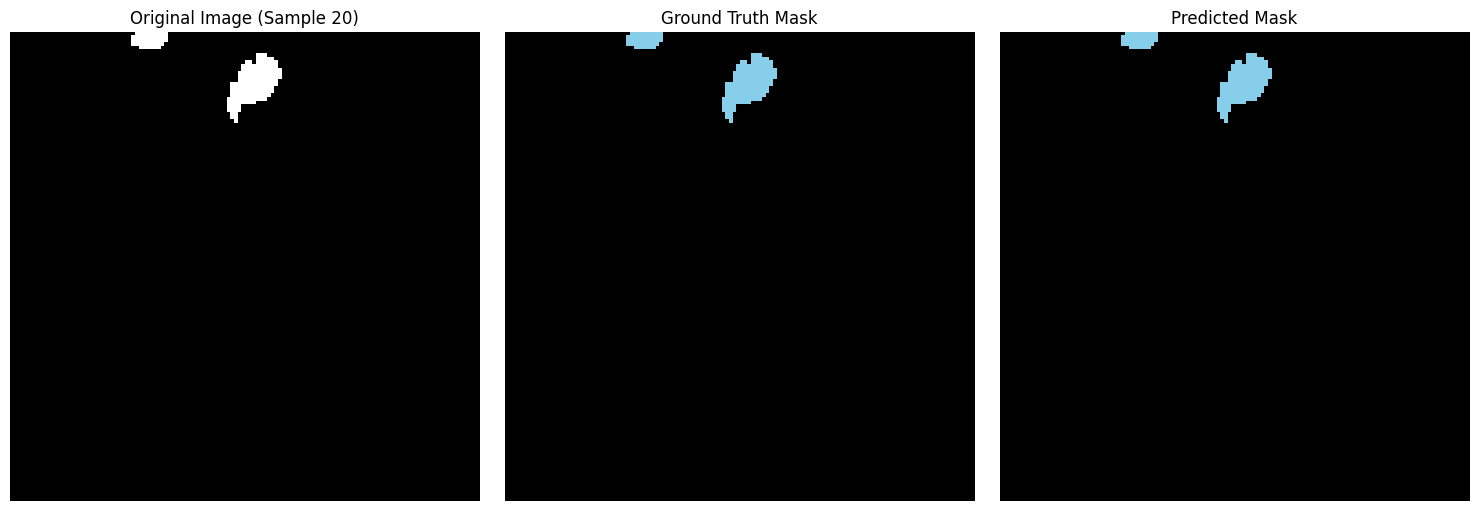

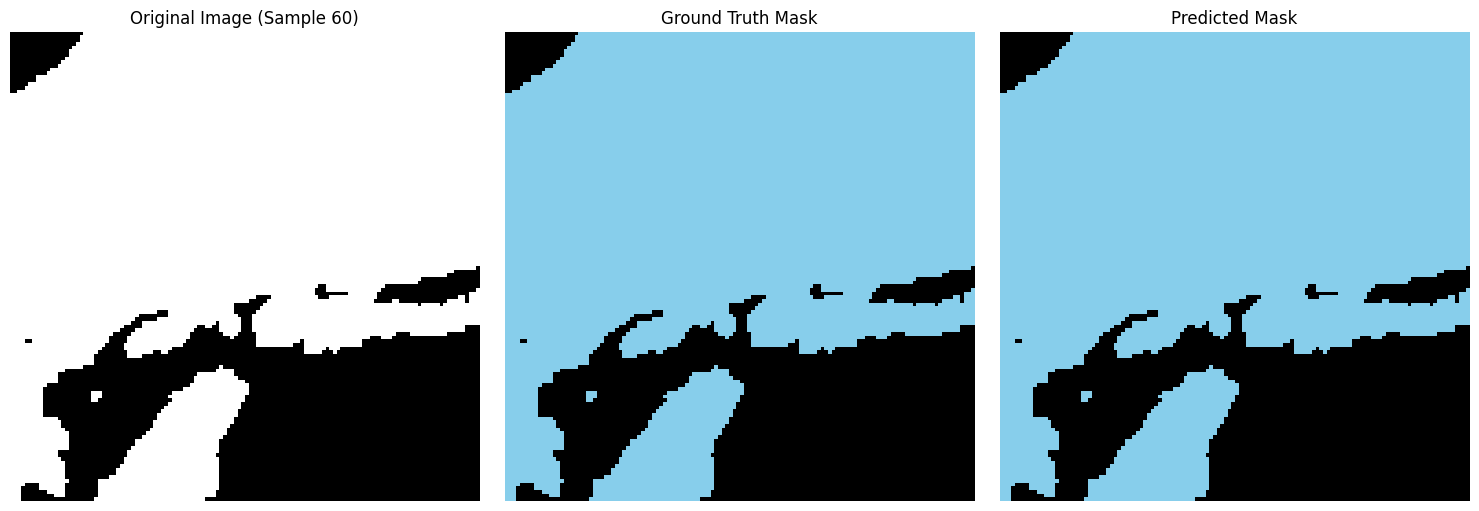

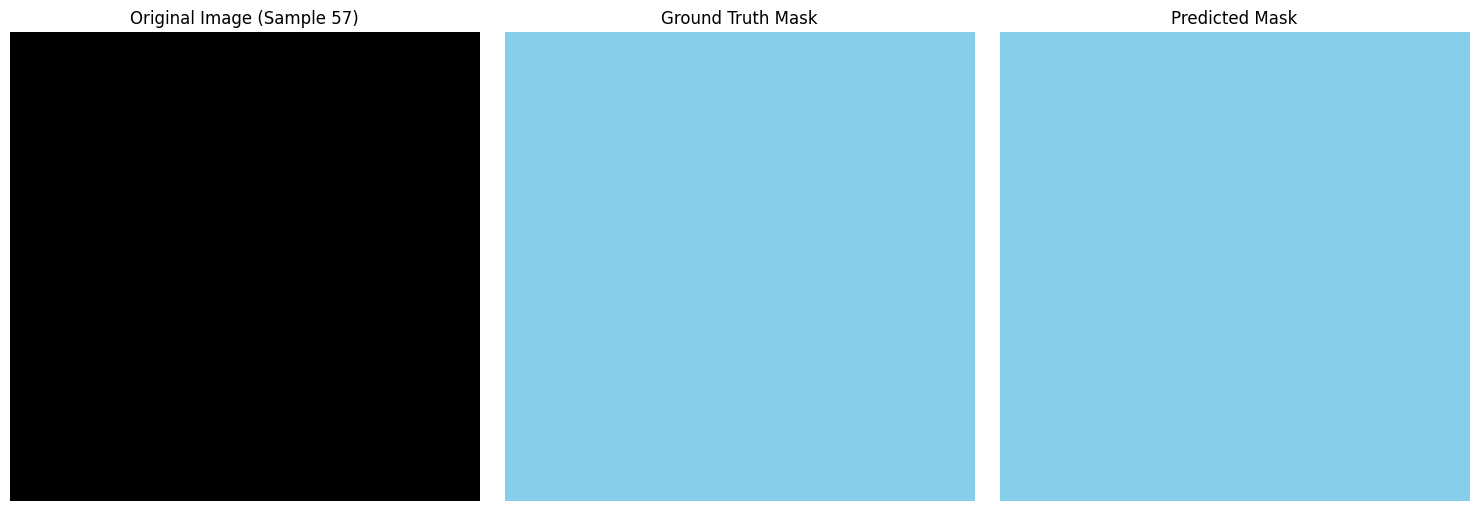

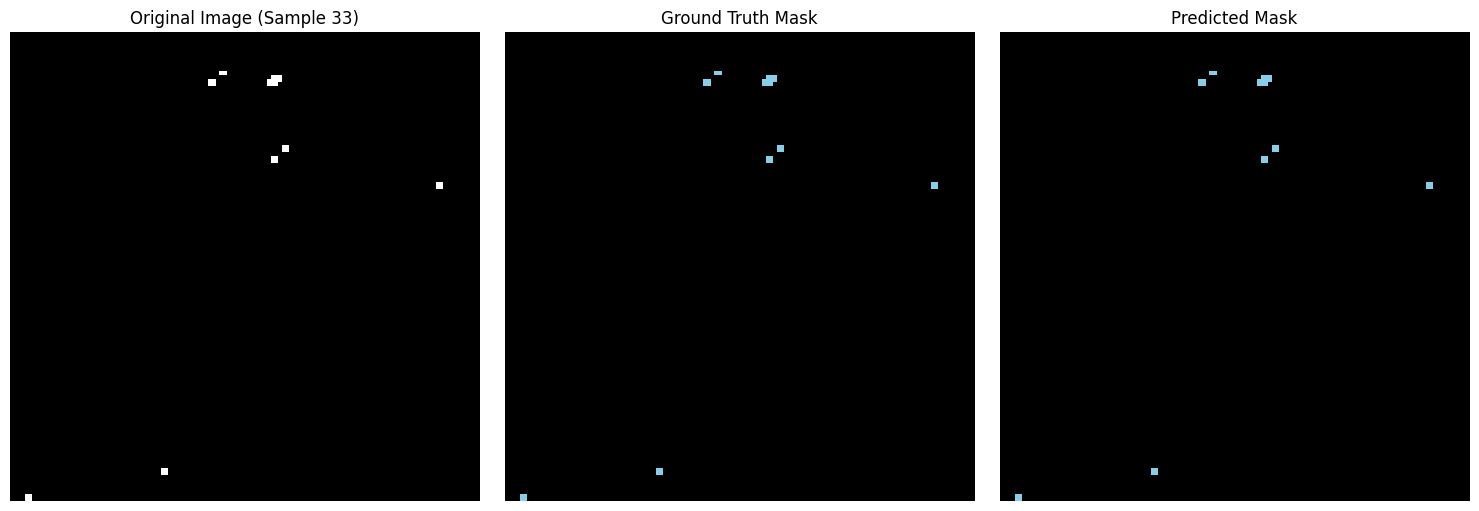

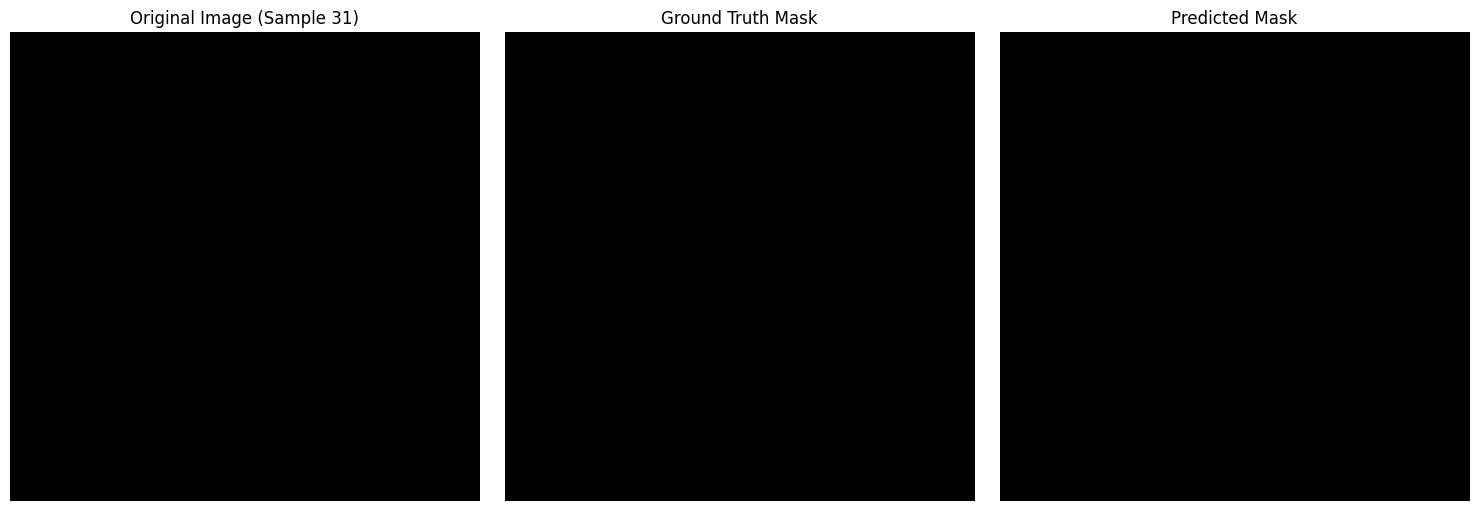

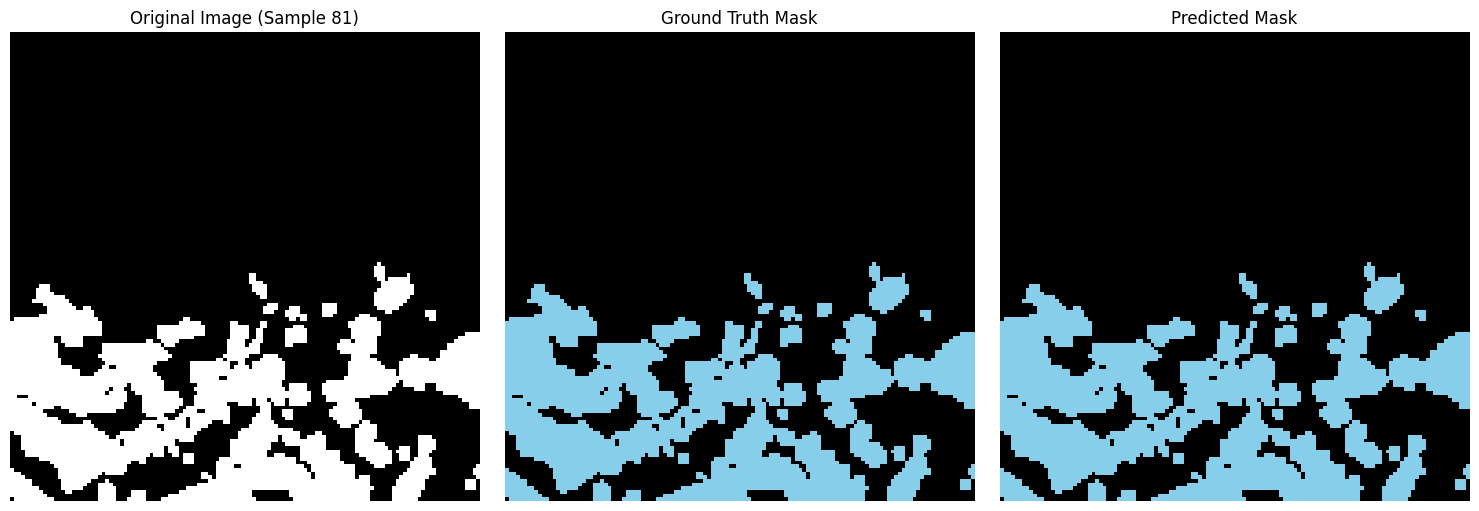

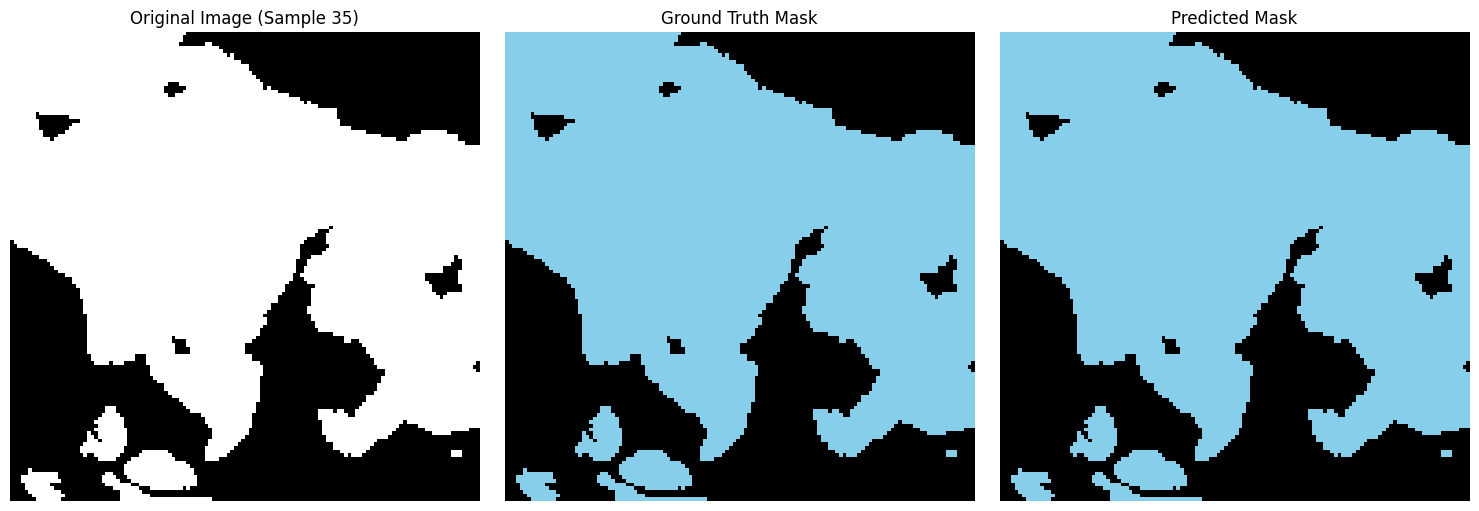

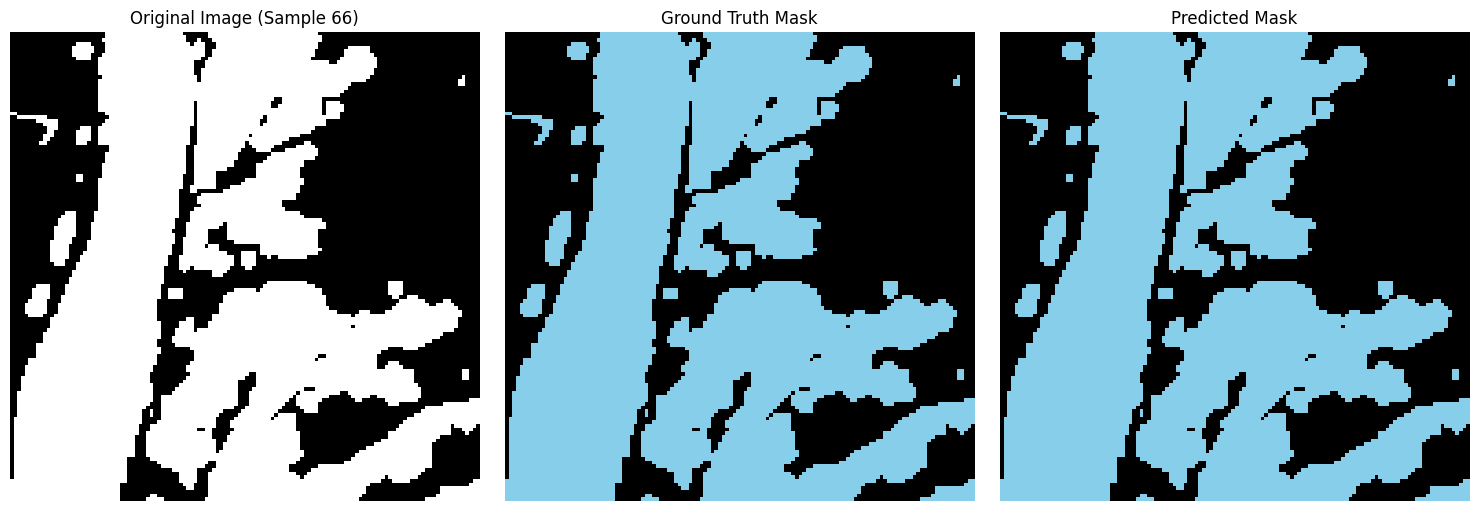

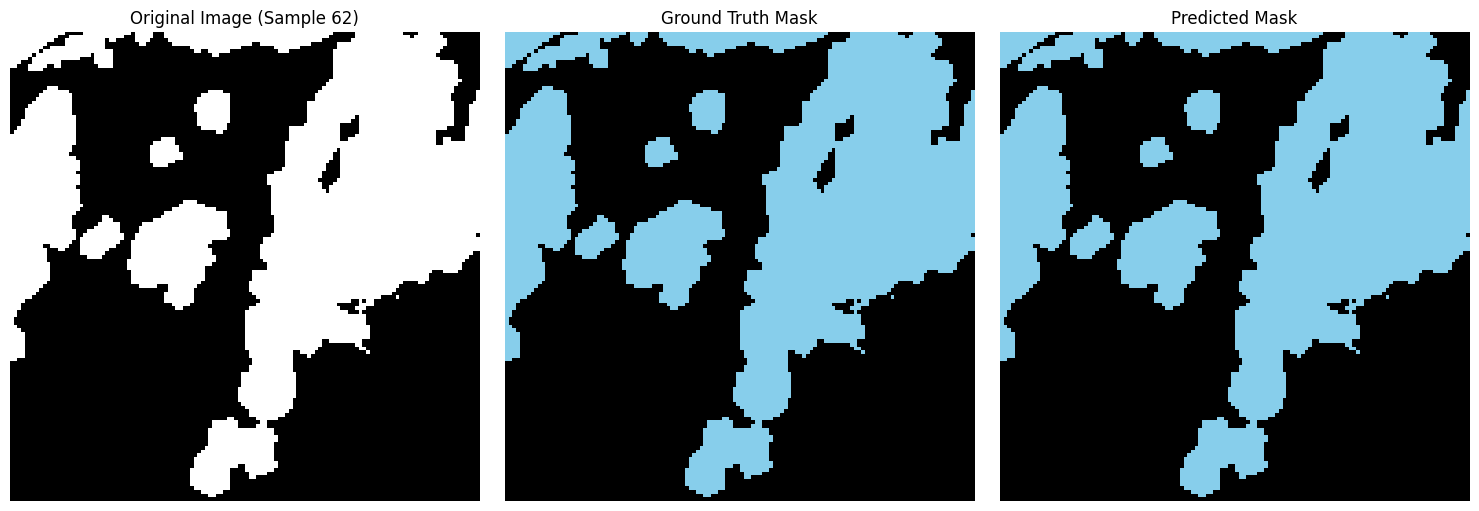

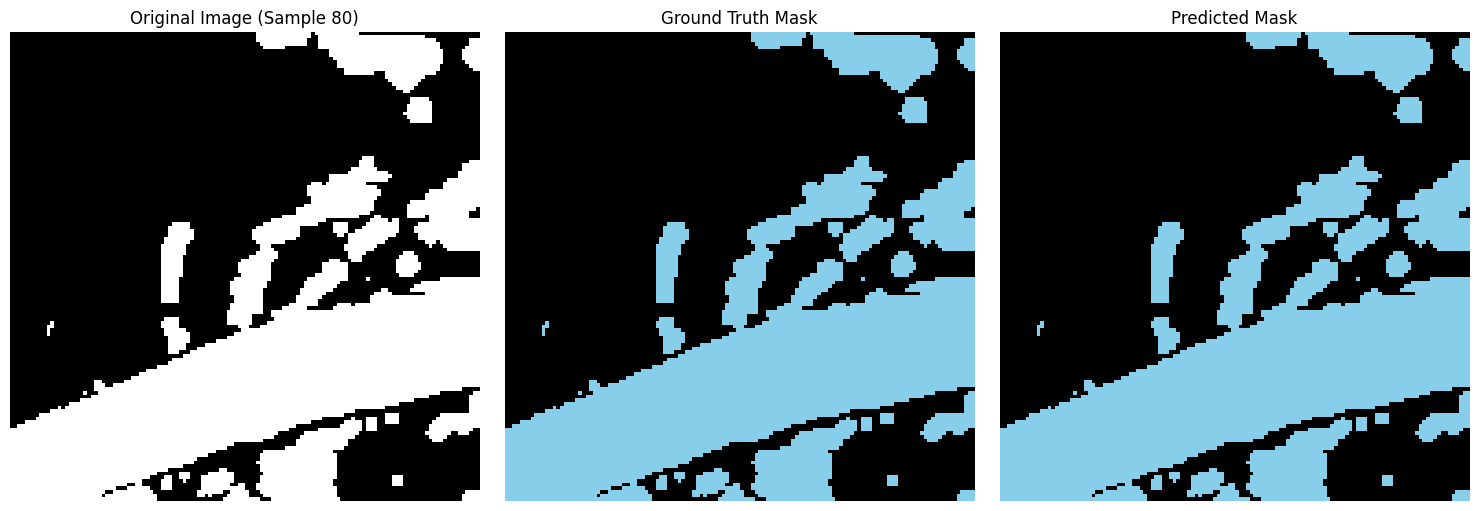

In [77]:
if 'val_imgs' in globals() and 'val_masks' in globals() and 'PREDICTED_MASKS_DIR' in globals():
     # Ensure val_masks is not None if you want to show ground truth
     if val_masks is not None:
         visualize_predictions_rgb(val_imgs, val_masks, PREDICTED_MASKS_DIR, num_samples=10)
     else:
         print("Ground truth masks (val_masks) are not available to plot.")
else:
    print("Required variables (val_imgs, val_masks, OUT_DIR) not found. Please run previous cells.")

Generating predictions on validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step
Flattened y_true shape: (1507328,)
Flattened y_pred shape: (1507328,)

Confusion Matrix:
[[962421      0]
 [    11 544896]]


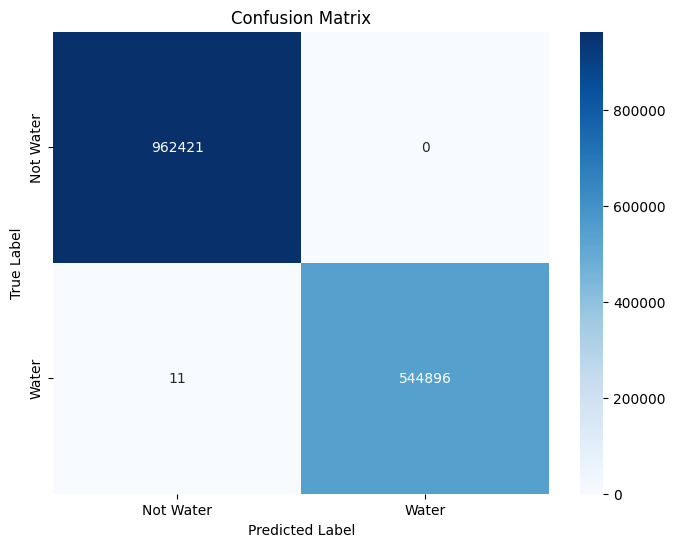


Classification Report:
              precision    recall  f1-score   support

   Not Water       1.00      1.00      1.00    962421
       Water       1.00      1.00      1.00    544907

    accuracy                           1.00   1507328
   macro avg       1.00      1.00      1.00   1507328
weighted avg       1.00      1.00      1.00   1507328



In [50]:
# 1. Generate Predictions
# Predict on the validation dataset. Use the unnormalized X_val if you want to use the original scale,
# but the model expects normalized data, so use the normalized X_val.
print("Generating predictions on validation set...")
y_pred_raw = nn_model.predict(X_val) # shape (N, H, W, 1)

# 2. Binarize Predictions
# Use a threshold to convert probabilities to binary masks (0 or 1)
threshold = 0.5
y_pred_bin = (y_pred_raw > threshold).astype(np.uint8) # shape (N, H, W, 1)

# 3. Flatten Masks
# Flatten the ground truth and predicted masks for scikit-learn functions
y_true_flat = Y_val.flatten() # shape (N * H * W * 1,)
y_pred_flat = y_pred_bin.flatten() # shape (N * H * W * 1,)

print(f"Flattened y_true shape: {y_true_flat.shape}")
print(f"Flattened y_pred shape: {y_pred_flat.shape}")

# 4. Compute Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
# The labels parameter defines the order of classes. Assuming 0=Not Water, 1=Water
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])

print("\nConfusion Matrix:")
print(cm)

# 5. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Water', 'Water'], yticklabels=['Not Water', 'Water'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6. Generate Classification Report
from sklearn.metrics import classification_report

# Generate the classification report
# target_names defines the names for the classes in the report
report = classification_report(y_true_flat, y_pred_flat, target_names=['Not Water', 'Water'])

# 7. Display Report
print("\nClassification Report:")
print(report)

# 8. Finish task
# The confusion matrix and classification report provide insights into the model's performance
# for each class (water and not water), showing metrics like precision, recall, and F1-score.

<hr style="border-top: 1px dashed #bbb;" />

- - - - - - - - - - - - -

<hr style="height:2px;border:none;color:#333;background-color:#333;" />